# Main Model for Handwritten Text Synthesis GAN

This model will consist of 4 major networks, following the general architecture of an GAN.

1. Encoder: Produces an embedding that will be concatenated with the noise vector.
2. Generator: Taking noise vector as input and the text embedding to produce an 128x2048 image.
3. Discriminator: Trained alternating with generator input and ground-truth input, binary classification real or fake.
4. Recognizer: Taking image as input, produce a vector representation of the text.

## Imports

In [2]:
import csv
import datetime
import os
import random
import re

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch_fidelity
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from torch.nn.utils.spectral_norm import spectral_norm
from torch.utils.data import DataLoader, Dataset, RandomSampler, Subset, random_split
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.text import CharErrorRate
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import Grayscale, Resize, ToPILImage, ToTensor
from torchvision.transforms.functional import InterpolationMode
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

## Data Loading

### Helper Functions (Run once only to format data)

In [3]:
SCALE_HEIGHT = 32
SCALE_WIDTH = SCALE_HEIGHT*16

def preprocess_lines(data_root):
    """
    Creates a new `.txt` file `lines_improved.txt` that will be used
    for querying. This new `.txt` file contains all info necessary
    for the functionality of this project.
    """

    original_path = os.path.join(data_root, "lines.txt")
    improved_path = os.path.join(data_root, "lines_improved.txt")
    fi = open(improved_path, "w")

    # Some variables for tracking
    num_samples = 0
    valid_samples = 0
    
    # Loop through "lines.txt"
    with open(original_path, "r") as fo:
        headers = ["image_id", "image_path", "image_pt_path", "graylevel", "original_height", "original_width", "transcription", "transcription_len"]

        # First write the headers at the top of the file
        fi.writelines("\t".join(headers) + "\n")

        # Skip the intro stuff
        for line in fo.readlines():
            if line.startswith("#"):
                continue

            # Valid lines, not the intro_text
            line_items = line.strip().split(" ")  # `strip()` to remove newlines

            # The actual items (we extract the important ones)
            image_id = line_items[0]
            status = line_items[1]
            graylevel = int(line_items[2])
            transcription = " ".join(line_items[8:])  # Some data has whitespace, we join string till the end

            # Skip error images
            if status == "err":
                continue
        
            # Alphanumeric + common punctuation regex
            # Returns None if no match
            # 26 + 26 + 10 + 9 + 1 = 72
            # Spaces might be included as well
            # Punctuation include , ! ? ' " , : ; -
            if re.fullmatch("[a-zA-Z0-9.!?'\",:;| -]*", transcription) is None:
                continue

            # Now we have valid transcription
            num_samples += 1

            # We get the `.png` image path
            inp = image_id.split("-")  # `inp` stands for image name parts
            image_path_head = os.path.join(data_root, "lines", inp[0], f"{inp[0]}-{inp[1]}")
            image_path_tail = f"{image_id}.png"
            image_path = os.path.join(image_path_head, image_path_tail)
            
            # Read image, gets its dimensions, perform processing operations, and other stuff
            tmp_image = cv.imread(os.path.join(image_path_head, image_path_tail), cv.IMREAD_GRAYSCALE)  # Removes the channel dimension
            height, width = tmp_image.shape

            # Scaling calculations
            # If width * scale >= desired length (>= to be safe)
            # Condition here to speed up overall processing time
            if width * (SCALE_HEIGHT/height) >= SCALE_WIDTH:
                continue

            resized_tensor = process_image(tmp_image, graylevel)
            image_pt_path = os.path.join(image_path_head, f"{image_id}.pt")
            torch.save(resized_tensor, image_pt_path)

            # A fully valid image
            # Separate by underscores because `transcription` has spaces so we can't split by spaces
            fi.writelines(f"{image_id}\t{image_path}\t{image_pt_path}\t{graylevel}\t{height}\t{width}\t{transcription}\t{len(transcription)}\n")
            valid_samples += 1
        
        fi.close()
    
    print("# samples:", num_samples)
    print("Valid samples:", valid_samples)


def process_image(cv_image, graylevel):
    """
    Takes in a grayscale image that OpenCV read of shape (H, W) of type uint8
    Returns a PyTorch tensor of shape (1, 32, W'), where W' is the scaled width
    This tensor is padded and effectively thresholded
    """

    # Scaling factor
    height, width = cv_image.shape
    scale = SCALE_HEIGHT/height
    scaled_width = int(width*scale)

    # Trick here is to apply threshold before resize and padding
    # This allows OpenCV resizing to create a cleaner output image
    # 2nd return value is the thresholded image
    output = cv.threshold(cv_image, graylevel, 255, cv.THRESH_BINARY)[1]

    # INTER_AREA recommended for sizing down
    output = cv.resize(output, (scaled_width, SCALE_HEIGHT), interpolation=cv.INTER_AREA)

    # Turn it back to a tensor and map to [0, 1]
    output = torch.from_numpy(output).unsqueeze(0).type(torch.float32)
    output = (output-output.min()) / (output.max()-output.min())
    
    # Add padding
    _, _, resized_height = output.shape
    padding_to_add = SCALE_WIDTH - resized_height
    output = F.pad(output, (0, padding_to_add), value=1.0)

    return output

# Uncomment this if your data isn't processed yet
# preprocess_lines("./data/")

### Integer ⇔ Char Mapping Dict (Run everytime before training)

In [4]:
# Sorted by ascii code
valid = [
    ' ', '!', '"', "'", ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
    ':', ';', '?', 
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
# Enumerate from 1 to save space for padding
# Reserve 0 for CTC blank
char_to_int = {v: i for i, v in enumerate(valid, 1)}
int_to_char = {i: v for i, v in enumerate(valid, 1)}

### Defining Dataset Class

In [5]:
class LineDataset(Dataset):
    def __init__(self, lines_improved_dir, ty=None):
        """
        params:
            lines_improved_dir: path to the `lines_improved.txt` file
            ty: type of the dataset "txt", "img" for text dataset or image dataset.
        """
        
        # Dataframe containing the stuff in `lines_improved.txt`
        self.lines_df = pd.read_csv(lines_improved_dir, sep="\t", quoting=csv.QUOTE_NONE)

        # Class properties
        self.ty = ty  # Type of dataset (lines, images, or both)
        self.max_transcription_len = max(self.lines_df["transcription_len"])

        # Temp variables...
        length = self.lines_df.shape[0]
        line_datas = self.lines_df.iloc
        ret_texts = [line_datas[i]["transcription"].replace('|', ' ') for i in range(length)]
        ret_ctois = [torch.tensor([char_to_int[char] for char in ret_texts[i]]) for i in range(length)]

        # ...for the important data
        if self.ty in ("txt", None):  # Added this condition to speed thigns up if only text
            self.ret_ctoi_paddeds = [F.pad(ret_ctois[i], pad=(0, self.max_transcription_len-len(ret_ctois[i]))) for i in range(length)]
        if self.ty in ("img", None):
            self.ret_images = [torch.load(line_datas[i]["image_pt_path"]) for i in range(length)]

    def __len__(self):
        return len(self.lines_df)
    
    def __getitem__(self, index):
        # Different type of individual loaders
        if self.ty == "txt":
            return self.ret_ctoi_paddeds[index]
        elif self.ty == "img":
            return self.ret_images[index]
        else:
            return self.ret_images[index], self.ret_ctoi_paddeds[index]

### Initializing Datasets and Subsets of Datasets

In [6]:
line_transcription_dataset = LineDataset("./data/lines_improved.txt", ty="txt")
line_image_dataset = LineDataset("./data/lines_improved.txt", ty="img")
line_dataset = LineDataset("./data/lines_improved.txt")

# Don't change this, we want to maintain consistent split
torch.manual_seed(12345678)  # DO NOT REMOVE THIS LINE
line_transcription_dataset_train, line_transcription_dataset_val = random_split(line_transcription_dataset, [0.8, 0.2])
line_image_dataset_train, line_image_dataset_val = random_split(line_image_dataset, [0.8, 0.2])
line_dataset_train, line_dataset_val = random_split(line_dataset, [0.8, 0.2])

# To train on a small dataset
line_transcription_dataset_train = Subset(line_transcription_dataset_train, range(100))
line_transcription_dataset_val = Subset(line_transcription_dataset_val, range(20))

line_image_dataset_train = Subset(line_image_dataset_train, range(100))
line_image_dataset_val = Subset(line_image_dataset_val, range(20))

line_dataset_train = Subset(line_dataset_train, range(2500))
line_dataset_val = Subset(line_dataset_val, range(500))

# line_transcription_dataset_train, line_transcription_dataset_val, _ = random_split(line_transcription_dataset, [0.005, 0.005, 0.99])
# line_image_dataset_train, line_image_dataset_val, _ = random_split(line_image_dataset, [0.005, 0.005, 0.99])
# line_dataset_train, line_dataset_val = random_split(line_dataset, [0.0025, 0.9975])

print("lines")
print(len(line_transcription_dataset_train), len(line_transcription_dataset_val))
print("images")
print(len(line_image_dataset_train), len(line_image_dataset_val))
print("both")
print(len(line_dataset_train), len(line_dataset_val))


lines
100 20
images
100 20
both
2500 500


### Showing Example Image and Label

torch.Size([1, 32, 512])
torch.Size([32, 512])
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


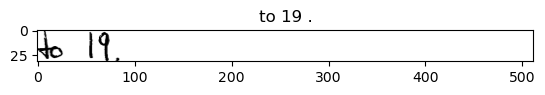

In [7]:
image, label = line_dataset_train[0]
print(image.shape)
plt.title("".join([int_to_char[int(val)] for val in label[label.nonzero()]]))
print(image.squeeze(0).shape)
plt.imshow(image.squeeze(0), cmap='gray')
label, "".join([int_to_char[int(val)] for val in label[label.nonzero()]])
# line_dataset.lines_df.iloc[798]
print(image)

## Define Key Functions

### Recognizer Related Functions

In [8]:
def calculate_recog_accuracy(preds, target):
    """
    Calculates the accuracy of the recognizer with character error rate
    which is based on edit distance

    Params:
        preds: a list of prediction strings
        targets: a list of target strings

    Returns:
        An integer, the character error rate average across
        all predictions and targets
    """

    cer = CharErrorRate()
    return cer(preds, target)


def create_strings_from_tensor(int_tensor):
    """
    Params:
        int_tensor: A shape (N, 82) tensor where each row corresponds to
        a integer mapping of a string. Includes padding
    
    Returns:
        A list of N strings
    """

    strings = []
    for string_map in int_tensor:
        strings.append("".join([int_to_char[int(i)] for i in string_map[string_map != 0]]))
    return strings

### Plotting and Evaluating Functions

In [9]:
"""Dataloading Functions"""
"""Datasaving Functions"""

"""Plotting Functions"""
"""Evaluation Functions"""
def calculate_gan_loss_and_accuracies(generator, encoder, discriminator, recognizer, 
                                  line_loader, fid_set,
                                  batch_size=64, adversarial_loss_function=nn.BCELoss(), recognizer_loss_function=nn.NLLLoss(),
                                  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), recognizer_downscale_factor=1):
    """
    Calculates the loss for the GAN
    
    Params:
        generator: The generator model
        encoder: The encoder model
        discriminator: The discriminator model
        recognizer: The recognizer model
        line_loader: The dataloader for lines and their corresponding texts
        batch_size: The batch size to use
        adversarial_loss_function: The adversarial loss function to use
        recognizer_loss_function: The recognizer loss function to use

    Returns:
        generator_and_encoder_loss: The loss for the generator and encoder
        discriminator_loss: The loss for the discriminator
    """
    fid_set.reset()  # Just to make sure
    generator_and_encoder_loss = 0
    discriminator_loss = 0
    discriminator_accuracy = 0
    recognizer_error = 0  # Character error rate
    with torch.no_grad():
        for i, (line_image_batch, input_text_batch) in enumerate(line_loader):
            line_image_batch = line_image_batch.to(device)
            input_text_batch = input_text_batch.to(device)

            # generate noise of N x noise_dim
            noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)

            # Use encoder and generator to generate fake images
            text_embedding = encoder(input_text_batch)
            fake_image_batch = generator(noise, text_embedding)

            # train discriminator
            discriminator_output_for_real_images = discriminator(line_image_batch)
            discriminator_output_for_fake_images = discriminator(fake_image_batch)
            label_for_real_images = torch.ones_like(discriminator_output_for_real_images).to(device)
            label_for_fake_images = torch.zeros_like(discriminator_output_for_fake_images).to(device)
            real_images_loss = adversarial_loss_function(discriminator_output_for_real_images, label_for_real_images)
            fake_images_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_fake_images)
            discriminator_loss_eval = (real_images_loss + fake_images_loss) / 2
            discriminator_loss += discriminator_loss_eval.item()
            discriminator_accuracy += (torch.sum(discriminator_output_for_real_images >= 0.5).item() + torch.sum(discriminator_output_for_fake_images < 0.5).item()) / (2 * batch_size)

            # train generator
            
            adversarial_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_real_images)
            recognizer_outputs = recognizer(fake_image_batch)
            recognizer_loss = recognizer_loss_function(
                # Takes input torch.Size([N, 73, 82])
                F.log_softmax(recognizer_outputs, 1),
                input_text_batch  # Shape N by 82
            )
            
            # Recognizer loss in general bigger than recognizer+encoder loss
            recognizer_loss = recognizer_loss / recognizer_downscale_factor
            
            generator_loss = adversarial_loss + recognizer_loss
            generator_and_encoder_loss += generator_loss.item()

            # calculate fid
            fid_set.update(fake_image_batch.cpu().repeat(1, 3, 1, 1), real=False)

            # Calculate recognizer error
            preds = create_strings_from_tensor(torch.argmax(recognizer_outputs, dim=1))
            target = create_strings_from_tensor(input_text_batch)
            recognizer_error += calculate_recog_accuracy(preds, target)
            print(f"[EVAL] processed batch {i}, disc_loss={discriminator_loss_eval} | ad_loss={adversarial_loss}, recog_loss={recognizer_loss}")

    generator_and_encoder_error = fid_set.compute().item()
    fid_set.reset()
    discriminator_accuracy /= len(line_loader)
    generator_and_encoder_loss /= len(line_loader)
    discriminator_loss /= len(line_loader)
    recognizer_error /= len(line_loader)

    return generator_and_encoder_loss, discriminator_loss, generator_and_encoder_error, discriminator_accuracy, recognizer_error

"""Training Functions"""
def train_recognizer(recognizer, train_line_loader, val_line_loader, batch_size=64, learning_rate=2e-4, betas=(0, 0.999), num_epochs=30):
    # only train on real images
    # also save model, plot graphs, save graphs
    pass

def train_gan(generator, encoder, discriminator, recognizer, 
              train_line_dataset, val_line_dataset,
              batch_size=64, encoder_lr=1e-5, generator_lr=1e-5, discriminator_lr=1e-5,
              betas=(0, 0.999), num_epochs=30, recognizer_downscale_factor=1,
              num_generator_updates_per_discriminator_update=1):
    # Note, the generator and discriminator should be spectrally normalized before training
    # TODO: load dataloader with batch size batch_size

    time_gan_init = f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    generator = generator.to(device)
    encoder = encoder.to(device)
    discriminator = discriminator.to(device)
    recognizer = recognizer.to(device)
    
    train_line_loader = DataLoader(train_line_dataset, batch_size=batch_size, shuffle=True)
    val_line_loader = DataLoader(val_line_dataset, batch_size=batch_size, shuffle=True)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=encoder_lr, betas=betas)
    generator_optimizer = optim.Adam(generator.parameters(), lr=generator_lr, betas=betas)
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=betas)
    
    adversarial_loss_function = nn.BCELoss()  # discriminator already has sigmoid
    recognizer_loss_function = nn.NLLLoss()
    saving_filenames = {
        "encoder": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lrE{encoder_lr}_lrG{generator_lr}_lrD{discriminator_lr}_betas{betas}_encoder"),
        "generator": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lrE{encoder_lr}_lrG{generator_lr}_lrD{discriminator_lr}_betas{betas}_generator"),
        "discriminator": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lrE{encoder_lr}_lrG{generator_lr}_lrD{discriminator_lr}_betas{betas}_discriminator"), 
        "losses": os.path.join("main_model", "model_training_information", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lrE{encoder_lr}_lrG{generator_lr}_lrD{discriminator_lr}_betas{betas}_losses"),
        "accuracies": os.path.join("main_model", "model_training_information", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lrE{encoder_lr}_lrG{generator_lr}_lrD{discriminator_lr}_accuracies"),
        "raw": os.path.join("main_model", "model_training_information_rawlist", f"{time_gan_init}_bs{batch_size}_lrE{encoder_lr}_lrG{generator_lr}_lrD{discriminator_lr}_rawlist")
        }

    best_generator_and_encoder_val_loss = float('inf')
    best_discriminator_val_loss = float('inf')
    best_generator_and_encoder_val_error = 0
    best_discriminator_val_accuracy = 0
    saved_generator_and_encoder_models_epochs = []
    saved_discriminator_models_epochs = []

    generator_and_encoder_train_losses = []
    discriminator_train_losses = []
    generator_and_encoder_train_accuracies = []
    discriminator_train_accuracies = []
    generator_and_encoder_val_losses = []
    discriminator_val_losses = []
    generator_and_encoder_val_accuracies = []
    discriminator_val_accuracies = []
    recognizer_train_errors = []
    recognizer_val_errors = []

    # FID: https://torchmetrics.readthedocs.io/en/stable/image/frechet_inception_distance.html
    print("FID on train and validation set (all images)")
    fid_set = FrechetInceptionDistance(feature=2048, reset_real_features=False, normalize=True)
    for i, (real_image_batch, _) in enumerate(train_line_loader):
        print(i, real_image_batch.shape)
        fid_set.update(real_image_batch.cpu().repeat(1, 3, 1, 1), real=True)
    for i, (real_image_batch, _) in enumerate(val_line_loader):
        print(i, real_image_batch.shape)
        fid_set.update(real_image_batch.cpu().repeat(1, 3, 1, 1), real=True)


    for epoch in range(num_epochs):
        display_images = []

        generator_and_encoder_train_loss = 0
        discriminator_train_loss = 0
        discriminator_train_accuracy = 0
        recognizer_train_error = 0
        
        times_discriminator_updated = 0

        for i, (real_image_batch, input_text_batch) in enumerate(train_line_loader):
            print("epoch", epoch, "batch", i)
            # print("real_image_batch.shape", real_image_batch.shape)
            # print("input_text_batch.shape", input_text_batch.shape)

            real_image_batch = real_image_batch.to(device)
            input_text_batch = input_text_batch.to(device)

            # generate noise of N x noise_dim
            noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)

            # Use encoder and generator to generate fake images
            text_embedding = encoder(input_text_batch)
            # print(noise.shape, text_embedding.shape)
            fake_image_batch = generator(noise, text_embedding)
            # We won't need to pass in real images to recognizer because we use pretrained
            # We pretrained the recognizer ourselves

            # display random image from the batch
            sample_text = input_text_batch[0][input_text_batch[0].nonzero()]
            sample_text = "".join([int_to_char[int(i)] for i in sample_text])
            example = fake_image_batch.cpu().detach().numpy()[0].squeeze(0)

            # Only train discriminator every num_generator_updates_per_discriminator_update iterations
            if i % num_generator_updates_per_discriminator_update == 0:
                times_discriminator_updated += 1
                # train discriminator
                discriminator_optimizer.zero_grad()
                # real_image_batch = real_image_batch.type(torch.float32)
                discriminator_output_for_real_images = discriminator(real_image_batch)
                discriminator_output_for_fake_images = discriminator(fake_image_batch.detach())  # added detatch to prevent gradients from flowing back to generator
                label_for_real_images = torch.ones_like(discriminator_output_for_real_images).to(device)*0.99  # To prevent discriminator from getting too confident
                label_for_fake_images = torch.zeros_like(discriminator_output_for_fake_images).to(device)+0.01  # To prevent discriminator from getting too confident
                real_images_loss = adversarial_loss_function(discriminator_output_for_real_images, label_for_real_images)
                fake_images_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_fake_images)
                discriminator_loss = (real_images_loss + fake_images_loss) / 2
                discriminator_loss.backward()  # retain_graph=True because we will use the same discriminator for the generator
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=0.5)
                
                discriminator_optimizer.step()
                discriminator_train_loss += discriminator_loss.item()
                discriminator_train_accuracy += (torch.sum(discriminator_output_for_real_images > 0.5) + torch.sum(discriminator_output_for_fake_images < 0.5)) / (2 * batch_size)
                print("[train] discriminator updated")

            # train generator
            generator_optimizer.zero_grad()
            encoder_optimizer.zero_grad()
            # # generate noise of N x noise_dim
            # noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)
            # # Use encoder and generator to generate fake images
            # text_embedding = encoder(input_text_batch)
            # fake_image_batch = generator(noise, text_embedding)
            # # display random image from the batch
            # plt.imshow(fake_image_batch.cpu().detach().numpy()[0].squeeze(0), cmap='gray')
            # plt.show()
            discriminator_output_for_fake_images = discriminator(fake_image_batch)
            adversarial_loss = adversarial_loss_function(discriminator_output_for_fake_images, torch.ones_like(discriminator_output_for_fake_images).to(device)*0.99)  # note that we want the fake images to be classified as real, also the *0.99 is to prevent generator from getting too confident
            # print(torch.sum(discriminator_output_for_fake_images > 0.5))
            # print(adversarial_loss)

            # Feed in fake images to the pretrained recognizer for decoding
            recognizer_outputs_from_fake = recognizer(fake_image_batch)
            # Apply NLLLoss()
            recognizer_loss = recognizer_loss_function(
                # Takes input torch.Size([N, 73, 82])
                F.log_softmax(recognizer_outputs_from_fake, 1),
                input_text_batch  # Shape N by 82
            )

            # Calculate recognizer error
            preds = create_strings_from_tensor(torch.argmax(recognizer_outputs_from_fake, dim=1))
            target = create_strings_from_tensor(input_text_batch)
            recognizer_train_error += calculate_recog_accuracy(preds, target)
            
            # Recognizer loss in general bigger than recognizer+encoder loss
            recognizer_loss = recognizer_loss / recognizer_downscale_factor
            
            generator_loss = adversarial_loss + recognizer_loss
            generator_loss.backward()
            # We do not update recognizer's gradients here
            # Recognizer does not train if we don't stop its optimizer, gradients just accumulate
            generator_optimizer.step()
            encoder_optimizer.step()
            generator_and_encoder_train_loss += generator_loss.item()
            
            # calculate FID
            fid_set.update(fake_image_batch.cpu().repeat(1, 3, 1, 1), real=False)

            # display_images.append(fake_image_batch[random.randint(0, len(fake_image_batch) - 1)].detach().numpy())

        # plot the collection of display_images, all are greyscale
        # display_images = np.array(display_images)
        # display_images = np.transpose(display_images, (0, 2, 3, 1))
        # display_images = np.squeeze(display_images)
        # plt.figure(figsize=(10, 10))
        # for i in range(25):
        #     plt.subplot(5, 5, i + 1)
        #     plt.imshow(display_images[i], cmap='gray')
        #     plt.axis('off')
        # plt.tight_layout()
        # plt.show()
        # plt.clf()
        print(sample_text)
        plt.imshow(example, cmap='gray')
        plt.show()

        # Tally up losses and accuracies
        generator_and_encoder_train_loss /= len(train_line_loader)
        discriminator_train_loss /= times_discriminator_updated
        generator_and_encoder_train_error = fid_set.compute().item()
        discriminator_train_accuracy /= times_discriminator_updated
        recognizer_train_error /= len(train_line_loader)
        fid_set.reset()
        # Appending them to the list
        generator_and_encoder_train_losses.append(generator_and_encoder_train_loss)
        discriminator_train_losses.append(discriminator_train_loss)
        generator_and_encoder_train_accuracies.append(generator_and_encoder_train_error)
        discriminator_train_accuracies.append(discriminator_train_accuracy.cpu().numpy())
        recognizer_train_errors.append(recognizer_train_error)

        generator_and_encoder_val_loss, discriminator_val_loss, generator_and_encoder_val_error, discriminator_val_accuracy, recognizer_val_error = calculate_gan_loss_and_accuracies(
            generator,
            encoder,
            discriminator,
            recognizer,
            val_line_loader,
            fid_set, batch_size=batch_size,
            recognizer_downscale_factor=recognizer_downscale_factor
        )
        generator_and_encoder_val_losses.append(generator_and_encoder_val_loss)
        discriminator_val_losses.append(discriminator_val_loss)
        generator_and_encoder_val_accuracies.append(generator_and_encoder_val_error)
        discriminator_val_accuracies.append(discriminator_val_accuracy)
        recognizer_val_errors.append(recognizer_val_error)

        print(f"Epoch {epoch}:\n\tGenerator and encoder train loss: {generator_and_encoder_train_loss}\n\tDiscriminator train loss: {discriminator_train_loss}\n\tGenerator and encoder train error: {generator_and_encoder_train_error}\n\tDiscriminator train accuracy: {discriminator_train_accuracy}\n\tGenerator and encoder val loss: {generator_and_encoder_val_loss}\n\tDiscriminator val loss: {discriminator_val_loss}\n\tGenerator and encoder val error: {generator_and_encoder_val_error}\n\tDiscriminator val accuracy: {discriminator_val_accuracy}\n\tRecognizer train error: {recognizer_train_error}\n\tRecognizer val error: {recognizer_val_error}")

        # Save models, only if they are better than the previous best
        if generator_and_encoder_val_loss < best_generator_and_encoder_val_loss:
            best_generator_and_encoder_val_loss = generator_and_encoder_val_loss
            saved_generator_and_encoder_models_epochs.append(epoch)
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if discriminator_val_loss < best_discriminator_val_loss:
            best_discriminator_val_loss = discriminator_val_loss
            saved_discriminator_models_epochs.append(epoch)
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if generator_and_encoder_val_error < best_generator_and_encoder_val_error:
            best_generator_and_encoder_val_error = generator_and_encoder_val_error
            saved_generator_and_encoder_models_epochs.append(epoch) if epoch not in saved_generator_and_encoder_models_epochs else None
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if discriminator_val_accuracy > best_discriminator_val_accuracy:
            best_discriminator_val_accuracy = discriminator_val_accuracy
            saved_discriminator_models_epochs.append(epoch) if epoch not in saved_discriminator_models_epochs else None
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")

        torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}_override.pt")
        torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}_override.pt")
        torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}_override.pt")
        # Save per epoch
        # save the losses and accuracies as csvs
        with open(f"{saving_filenames['raw']}.txt", "w") as f:
            names = ["generator_and_encoder_train_losses",
                         "discriminator_train_losses",
                         "generator_and_encoder_train_accuracies",
                         "discriminator_train_accuracies",
                         "generator_and_encoder_val_losses",
                         "discriminator_val_losses",
                         "generator_and_encoder_val_accuracies",
                         "discriminator_val_accuracies",
                         "recognizer_train_errors",
                         "recognizer_val_errors",
                         "saved_generator_and_encoder_models_epochs",
                         "saved_discriminator_models_epochs",]

            for i, li in enumerate([generator_and_encoder_train_losses,
                      discriminator_train_losses,
                      generator_and_encoder_train_accuracies,
                      discriminator_train_accuracies,
                      generator_and_encoder_val_losses,
                      discriminator_val_losses,
                      generator_and_encoder_val_accuracies,
                      discriminator_val_accuracies,
                      recognizer_train_errors,
                      recognizer_val_errors,
                      saved_generator_and_encoder_models_epochs,
                      saved_discriminator_models_epochs
            ]):
                f.write(f"{names[i]}: {list(map(float, li))}"+'\n')
        # # plot title
        # plt.title("generator and encoder losses")
        # # plot x axis label
        # plt.xlabel("epoch")
        # # plot y axis label
        # plt.ylabel("loss")
        # # plot the epoch vs the loss
        # plt.plot(range(epoch+1), generator_and_encoder_train_losses, label="train")
        # plt.plot(range(epoch+1), generator_and_encoder_val_losses, label="val")
        # # plot the saved models as dots
        # plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_losses[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
        # # legend
        # plt.legend()
        # # show the plot
        # plt.show()
        # # save the plot
        # plt.close()

        # # plot title
        # plt.title("discriminator losses")
        # # plot x axis label
        # plt.xlabel("epoch")
        # # plot y axis label
        # plt.ylabel("loss")
        # # plot the epoch vs the loss
        # plt.plot(range(epoch+1), discriminator_train_losses, label="train")
        # plt.plot(range(epoch+1), discriminator_val_losses, label="val")
        # # plot the saved models as dots
        # plt.scatter(saved_discriminator_models_epochs, [discriminator_val_losses[i] for i in saved_discriminator_models_epochs], label="saved models")
        # # legend
        # plt.legend()
        # # show the plot
        # plt.show()
        # # close the plot
        # plt.close()

        # # plot title
        # plt.title("generator and encoder errors")
        # # plot x axis label
        # plt.xlabel("epoch")
        # # plot y axis label
        # plt.ylabel("accuracy")
        # # plot the epoch vs the accuracy
        # plt.plot(range(epoch+1), generator_and_encoder_train_accuracies, label="train")
        # plt.plot(range(epoch+1), generator_and_encoder_val_accuracies, label="val")
        # # plot the saved models as dots
        # plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_accuracies[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
        # # legend
        # plt.legend()
        # # show the plot
        # plt.show()
        # # close the plot
        # plt.close()

        # # plot title
        # plt.title("discriminator accuracies")
        # # plot x axis label
        # plt.xlabel("epoch")
        # # plot y axis label
        # plt.ylabel("accuracy")
        # # plot the epoch vs the accuracy
        # plt.plot(range(epoch+1), discriminator_train_accuracies, label="train")
        # plt.plot(range(epoch+1), discriminator_val_accuracies, label="val")
        # # plot the saved models as dots
        # plt.scatter(saved_discriminator_models_epochs, [discriminator_val_accuracies[i] for i in saved_discriminator_models_epochs], label="saved models")
        # # legend
        # plt.legend()
        # # show the plot
        # plt.show()
        # # close the plot
        # plt.close()

    # Plot the losses and accuracies, and save them (filename should be unique, use datetime as a prefix)
    # The plot should include which epoch's model we saved
    # save the plot, and csv of the losses and accuracies, and which epoch's model we saved
    
    # plot title
    plt.title("generator and encoder losses")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("loss")
    # plot the epoch vs the loss
    plt.plot(range(num_epochs), generator_and_encoder_train_losses, label="train")
    plt.plot(range(num_epochs), generator_and_encoder_val_losses, label="val")
    # plot the saved models as dots
    plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_losses[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['losses']}_generator_and_encoder_loss.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("discriminator losses")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("loss")
    # plot the epoch vs the loss
    plt.plot(range(num_epochs), discriminator_train_losses, label="train")
    plt.plot(range(num_epochs), discriminator_val_losses, label="val")
    # plot the saved models as dots
    plt.scatter(saved_discriminator_models_epochs, [discriminator_val_losses[i] for i in saved_discriminator_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['losses']}_discriminator_loss.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("generator and encoder errors")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("error")
    # plot the epoch vs the accuracy
    plt.plot(range(num_epochs), generator_and_encoder_train_accuracies, label="train")
    plt.plot(range(num_epochs), generator_and_encoder_val_accuracies, label="val")
    # plot the saved models as dots
    plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_accuracies[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['accuracies']}_generator_and_encoder_error.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("discriminator accuracies")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("accuracy")
    # plot the epoch vs the accuracy
    plt.plot(range(epoch+1), discriminator_train_accuracies, label="train")
    plt.plot(range(epoch+1), discriminator_val_accuracies, label="val")
    # plot the saved models as dots
    plt.scatter(saved_discriminator_models_epochs, [discriminator_val_accuracies[i] for i in saved_discriminator_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['accuracies']}_discriminator_accuracy.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("recognizer errors")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("error")
    # plot the epoch vs the accuracy
    plt.plot(range(num_epochs), recognizer_train_errors, label="train")
    plt.plot(range(num_epochs), recognizer_val_errors, label="val")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['accuracies']}_recognizer_error.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()


    # save the losses and accuracies as csvs
    with open(f"{saving_filenames['losses']}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "generator and encoder train loss", "discriminator train loss", "generator and encoder val loss", "discriminator val loss"])
        for i in range(num_epochs):
            writer.writerow([i, generator_and_encoder_train_losses[i], discriminator_train_losses[i], generator_and_encoder_val_losses[i], discriminator_val_losses[i]])
    with open(f"{saving_filenames['accuracies']}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "generator and encoder train error", "discriminator train accuracy", "recognizer train error", "generator and encoder val error", "discriminator val accuracy", "recognizer val error"])
        for i in range(num_epochs):
            writer.writerow([i, generator_and_encoder_train_accuracies[i], discriminator_train_accuracies[i], recognizer_train_errors[i], generator_and_encoder_val_accuracies[i], discriminator_val_accuracies[i], recognizer_val_errors[i]])


def load_model(model, model_filename):
    """
    Load a model from a file.
    """
    model.load_state_dict(torch.load(model_filename))
    return model


def load_models_of_same_batch(generator, encoder, discriminator, filename_prefix, epoch_number):
    """
    Load the generator, encoder, and discriminator from files.
    """
    generator = load_model(generator, f"{filename_prefix}_generator_epoch{epoch_number}.pt")
    encoder = load_model(encoder, f"{filename_prefix}_encoder_epoch{epoch_number}.pt")
    discriminator = load_model(discriminator, f"{filename_prefix}_discriminator_epoch{epoch_number}.pt")
    return generator, encoder, discriminator

## Define Network Classes

### Generator Network Modules

In [10]:
class ConditionalBatchNorm2d(nn.Module):
    """
    Input: (N, C, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, C, H, W)

    Conditional Batch Normalization
    Idea obtained from https://arxiv.org/pdf/1809.11096.pdf
    This is a network layer that applies batch normalization to the input tensor, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and applies batch normalization to the input tensor. 
    Then it computes 2 affine parameters (scale and bias) for each channel of the input tensor, conditioned on the condition vector through a linear layer.
    The affine parameters are then applied to the input tensor, and the output is returned.
    """
    def __init__(self, in_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        num_conditions: length of the condition vector
        """
        super(ConditionalBatchNorm2d, self).__init__()
        self.in_channels = in_channels

        # batch normalize the input, without using affine parameters
        self.batch_norm = nn.BatchNorm2d(in_channels, affine=False)

        # set up affine parameters conditioned on the condition vector
        self.embed_conditions = nn.Sequential(
            # 512 hidden units are used by https://arxiv.org/pdf/1903.00277.pdf
            nn.Linear(num_conditions, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, in_channels * 2)
        )
        # # https://arxiv.org/pdf/1809.11096.pdf
        # # initialize affine parameters to be all zeros for bias and ones for scale
        # self.embed_conditions[-1].weight.data.zero_()
        # self.embed_conditions[-1].bias.data[:in_channels].zero_()  # bias is the second half of the affine parameters
        # self.embed_conditions[-1].bias.data[in_channels:].fill_(1)
        

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # apply batch normalization, out still has shape (N, C, H, W)
        out = self.batch_norm(x)

        # compute affine parameters
        params = self.embed_conditions(conditions)
        # params has shape (N, 2 * C), we split the channel dimension in half into 2 tensors of shape (N, C)
        scale, bias = params.chunk(2, dim=1)

        # Apply spectral normalization to the scale and bias
        scale = scale.view(-1, self.in_channels, 1, 1)
        bias = bias.view(-1, self.in_channels, 1, 1)

        # apply scale and bias. every channel's values are scaled and biased by the channel's own scale and bias value
        out = scale.view(-1, self.in_channels, 1, 1) * out + bias.view(-1, self.in_channels, 1, 1)

        # out has shape (N, C, H, W)
        return out
    
class ResBlockUp(nn.Module):
    """
    Input: (N, in_channels, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, out_channels, H * 2, W * 2)

    Residual Block for Upsampling
    Idea obtained from https://arxiv.org/pdf/1903.00277.pdf
    This is a network layer that upsamples the input tensor by a factor of 2, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and upsamples the input tensor by a factor of 2, accounting for the condition vector.
    """
    def __init__(self, in_channels, out_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor
        num_conditions: length of the condition vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockUp, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.relu = nn.ReLU(inplace=True)

        self.batch_norm1 = ConditionalBatchNorm2d(in_channels, num_conditions)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = ConditionalBatchNorm2d(out_channels, num_conditions)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # upsample the input tensor
        out1 = self.upsample(x)
        # depending on if this res_block_up changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        # second part of the res_block_up
        out2 = self.batch_norm1(x, conditions)
        out2 = self.relu(out2)
        out2 = self.upsample(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2, conditions)
        out2 = self.relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, 2 * H, 2 * W)
        
        out = out1 + out2
        return out
    
class SelfAttention(nn.Module):
    """Self attention Layer
    
    This code is obtained from https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py
    """

    def __init__(self,in_dim):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1) #

    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

### Discriminator Network Modules

In [11]:
class ResBlockDown(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockDown, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.01, inplace=True)
        self.average_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        out1 = self.average_pool(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        out2 = self.average_pool(out2)
        
        # the output has shape (N, out_channels, H / 2, W / 2)
        out = out1 + out2
        return out
    
class ResBlock(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlock, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.01, inplace=True)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, H, W)
        out = out1 + out2
        return out
    
class GlobalSumPooling(nn.Module):
    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)

        returns a tensor of shape (N, C)
        """
        return torch.sum(x, dim=(2, 3))

### Define Main Networks

In [12]:
class Encoder(nn.Module):
    """
    RNN
    Input with a vector representation of an ascii text
    Output a vector embedding of the text
    Purpose is to produce an embedding of the text that includes the relationship between the characters
    Description of the encoder comes from https://arxiv.org/pdf/1903.00277.pdf.
    Although we may end up modifying the dimensions of the hidden state and the embedding vector, 
    to fit our needs of processing longer texts.
    """

    def __init__(self, char_embedding_dim=128, hidden_dim=256, num_layers=6, num_chars=73):
        """
        embedding_dim: dimension of the embedding vector
        hidden_dim: dimension of the hidden state of the LSTM
        num_layers: number of layers in the LSTM
        num_chars: number of characters in the vocabulary
        """
        super(Encoder, self).__init__()

        self.char_embedding_dim = char_embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_chars = num_chars

        # TODO: embedding can be from a pretrained model
        self.embedding = nn.Embedding(num_chars, char_embedding_dim)
        # Using bidirectional LSTM. Batch first so that the input is of shape (N, L, C)
        self.lstm = nn.LSTM(char_embedding_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True)

    def forward(self, x):
        """
        x: input tensor of shape (N, L), where L is the length of the text. each element is an integer representing a character (1 to 72)
        """
        # Technically, L is the MAXIMUM length of the text in this batch (cuz padding)
        
        # First embed each character
        x = self.embedding(x)  # output should be (N, L, char_embedding_dim)

        # Run the LSTM, we will only use the hidden state, the sequence output is not needed
        out, _ = self.lstm(x)
        
        # TODO: this can be modified to specify how to reshape our output
        # out = out[:, -1, :]
        out, _ = torch.max(out, dim=1)
        # out, _ = torch.mean(out, dim=1)
        
        # out now have shape (N, hidden_dim * 2)
        return out

class Generator(nn.Module):
    """
    Transposed CNN
    Input with a vector embedding of the text and a noise vector
    Output a 128 x 2048 grayscale image
    Purpose is to produce an image that is a representation of the text, with the noise vector adding some variation
    """

    def __init__(self, noise_dim=96, embedding_dim=512):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 6
        embedding_dim: dimension of the embedding vector (2 * hidden_dim of the encoder)

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Generator, self).__init__()

        # We are likely going to need to use 5 ResBlockUp layers to get the image to the desired size of 128 x 2048
        # We will upscale to this from a 1 x 16 tensor
        # 5 ResBlockUp also mean our noise vector will be split into 6 parts. 
        self.noise_dim = noise_dim
        self.noise_chunk_size = noise_dim // 6
        self.embedding_dim = embedding_dim
        self.fc = spectral_norm(nn.Linear(self.noise_chunk_size, 256 * 1 * 16))
        self.res_block_up1 = ResBlockUp(256, 256, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up2 = ResBlockUp(256, 128, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up3 = ResBlockUp(128, 64, self.embedding_dim + self.noise_chunk_size)
        self.self_attention = SelfAttention(64)
        self.res_block_up4 = ResBlockUp(64, 32, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up5 = ResBlockUp(32, 16, self.embedding_dim + self.noise_chunk_size)
        self.batch_norm = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.conv = spectral_norm(nn.Conv2d(16, 1, kernel_size=3, padding=1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, noise, embedding):
        """
        noise: noise vector of shape (N, noise_dim)
        embedding: embedding of the text of shape (N, embedding_dim)
        """

        # split the noise vector into 8 parts
        noise_chunks = torch.split(noise, self.noise_chunk_size, dim=1)

        # first input to the network is the first noise chunk
        x = noise_chunks[0]
        # pass the concatenated tensor through the fully connected layer
        x = self.fc(x)  # output is (N, 256 * 1 * 16)
        # reshape the tensor to have the desired shape
        x = x.view(-1, 256, 1, 16)  # (N, 256, 1, 16)
        # pass the tensor through the ResBlockUp layers
        x = self.res_block_up1(x, torch.cat((embedding, noise_chunks[1]), dim=1))  # (N, 256, 2, 32)
        x = self.res_block_up2(x, torch.cat((embedding, noise_chunks[2]), dim=1))  # (N, 128, 4, 64)
        x = self.res_block_up3(x, torch.cat((embedding, noise_chunks[3]), dim=1))  # (N, 64, 8, 128)
        x = self.self_attention(x)  # (N, 64, 8, 128)
        x = self.res_block_up4(x, torch.cat((embedding, noise_chunks[4]), dim=1))  # (N, 32, 16, 256)
        x = self.res_block_up5(x, torch.cat((embedding, noise_chunks[5]), dim=1))  # (N, 16, 32, 512)
        # pass the tensor through the batch norm layer
        x = self.batch_norm(x)  # (N, 16, 32, 512)
        # pass the tensor through the relu layer
        x = self.relu(x)  # (N, 16, 32, 512)
        # pass the tensor through the convolution layer
        x = self.conv(x)  # (N, 1, 32, 512)
        # pass the tensor through the sigmoid
        x = self.sigmoid(x)  # (N, 1, 32, 512)

        return x

class Discriminator(nn.Module):
    """
    CNN
    Input with a 128 x 2048 grayscale image
    Output a probability that the image is real and not generated
    Purpose is to determine if the image is real or generated, to encourage the generator to produce realistic images
    """
    def __init__(self):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 8
        embedding_dim: dimension of the embedding vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Discriminator, self).__init__()

        self.res_block_down1 = ResBlockDown(1, 16)
        self.res_block_down2 = ResBlockDown(16, 32)
        self.self_attention = SelfAttention(32)
        self.res_block_down3 = ResBlockDown(32, 64)
        self.res_block_down4 = ResBlockDown(64, 128)
        self.res_block_down5 = ResBlockDown(128, 256)
        self.res_block = ResBlock(256, 256)
        self.global_sum_pooling = GlobalSumPooling()
        self.fc = spectral_norm(nn.Linear(256, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, image):
        """
        image: image tensor of shape (N, 1, 128, 2048)
        """

        # pass the tensor through the ResBlockDown layers
        x = self.res_block_down1(image)  # (N, 16, 16, 256)
        x = self.res_block_down2(x)   # (N, 32, 8, 128)
        x = self.self_attention(x)  # (N, 32, 8, 128)
        x = self.res_block_down3(x)  # (N, 64, 4, 64)
        x = self.res_block_down4(x)  # (N, 128, 2, 32)
        x = self.res_block_down5(x)  # (N, 256, 1, 16)
        # pass the tensor through the ResBlock layer
        x = self.res_block(x)  # (N, 256, 1, 16)
        # pass the tensor through the global sum pooling layer
        x = self.global_sum_pooling(x)  # (N, 256)
        # pass the tensor through the fully connected layer
        x = self.fc(x)  # (N, 1)
        # pass the tensor through the sigmoid
        x = self.sigmoid(x)  # (N, 1)

        return x
    pass

class Recognizer(nn.Module):
    """
    RNN:
    Input with a N x 1 x 32 x 512 image
    Output a vector representation of the text size N x 73 x (82*2+1)
    Purpose is to recognize the text from the image, to encourage the generator to produce images that are representations of the text
    """
    
    def __init__(self):
        super().__init__()
        self.name = "recognizer"
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4,2))
        self.bn4 = nn.BatchNorm2d(num_features=64)
        #self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,2))
        #xself.bn5 = nn.BatchNorm2d(num_features=128)
        #self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4,2))
        #self.bn6 = nn.BatchNorm2d(num_features=256)
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=4, bidirectional=True, batch_first=True)
        self.dense = nn.Linear(256, 73)
        self.dense2 = nn.Linear(505, 82)
        
        #self.fc = nn.Linear(10, 82)

        self.lrelu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(p=0.2)
        
    def forward(self, img):
        img = self.bn1(self.lrelu(self.conv1(img)))
        #print(img.shape)
        img = self.bn2(self.lrelu(self.conv2(img)))
        #print(img.shape)
        img = self.bn3(self.lrelu(self.dropout(self.conv3(img))))
        #print(img.shape)
        img = self.bn4(self.lrelu(self.dropout(self.conv4(img))))
        #print(img.shape)
        #img = self.bn5(self.lrelu(self.dropout(self.conv5(img))))
        #print(img.shape)
        # Collapse 
        img, _ = torch.max(img, dim=2)
        #print(img.shape)
        img = img.permute(0, 2, 1)
        #print(img.shape)
        img, _ = self.lstm(img)
        #print(img.shape)
        img = self.lrelu(self.dense(img))
        #print(img.shape)
        img = img.permute(0,2,1)
        img = self.lrelu(self.dense2(img))
        
        #img = self.fc(img)
        #print(img.shape)
        #print(img.shape)
        return img
        # img = torch.stack()
        # img = self.dense(img)

## Network Training and Evaluation

### Train Actual Network

cuda
FID on train and validation set (all images)
0 torch.Size([32, 1, 32, 512])
1 torch.Size([32, 1, 32, 512])
2 torch.Size([32, 1, 32, 512])
3 torch.Size([32, 1, 32, 512])
4 torch.Size([32, 1, 32, 512])
5 torch.Size([32, 1, 32, 512])
6 torch.Size([32, 1, 32, 512])
7 torch.Size([32, 1, 32, 512])
8 torch.Size([32, 1, 32, 512])
9 torch.Size([32, 1, 32, 512])
10 torch.Size([32, 1, 32, 512])
11 torch.Size([32, 1, 32, 512])
12 torch.Size([32, 1, 32, 512])
13 torch.Size([32, 1, 32, 512])
14 torch.Size([32, 1, 32, 512])
15 torch.Size([32, 1, 32, 512])
16 torch.Size([32, 1, 32, 512])
17 torch.Size([32, 1, 32, 512])
18 torch.Size([32, 1, 32, 512])
19 torch.Size([32, 1, 32, 512])
20 torch.Size([32, 1, 32, 512])
21 torch.Size([32, 1, 32, 512])
22 torch.Size([32, 1, 32, 512])
23 torch.Size([32, 1, 32, 512])
24 torch.Size([32, 1, 32, 512])
25 torch.Size([32, 1, 32, 512])
26 torch.Size([32, 1, 32, 512])
27 torch.Size([32, 1, 32, 512])
28 torch.Size([32, 1, 32, 512])
29 torch.Size([32, 1, 32, 512])


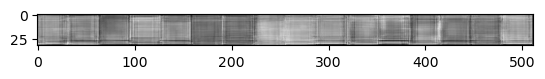

[EVAL] processed batch 0, disc_loss=0.9878727197647095 | ad_loss=1.015281081199646, recog_loss=20.131534576416016
[EVAL] processed batch 1, disc_loss=0.846737265586853 | ad_loss=0.9987143278121948, recog_loss=17.269176483154297
[EVAL] processed batch 2, disc_loss=0.9025669693946838 | ad_loss=0.9937503933906555, recog_loss=19.62325096130371
[EVAL] processed batch 3, disc_loss=0.972653329372406 | ad_loss=1.0201789140701294, recog_loss=22.298343658447266
[EVAL] processed batch 4, disc_loss=0.9002829790115356 | ad_loss=1.0414214134216309, recog_loss=17.84283447265625
[EVAL] processed batch 5, disc_loss=0.8905423879623413 | ad_loss=1.0274823904037476, recog_loss=20.20219612121582
[EVAL] processed batch 6, disc_loss=0.9148225784301758 | ad_loss=1.0649126768112183, recog_loss=20.25363540649414
[EVAL] processed batch 7, disc_loss=0.9185609221458435 | ad_loss=0.9084086418151855, recog_loss=23.078901290893555
[EVAL] processed batch 8, disc_loss=0.8298750519752502 | ad_loss=1.0256001949310303, re

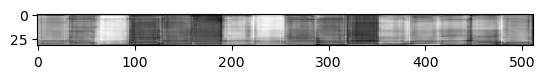

[EVAL] processed batch 0, disc_loss=0.7050240635871887 | ad_loss=1.0749815702438354, recog_loss=18.620656967163086
[EVAL] processed batch 1, disc_loss=0.7111321091651917 | ad_loss=1.0957434177398682, recog_loss=18.706918716430664
[EVAL] processed batch 2, disc_loss=0.6297135353088379 | ad_loss=1.0203566551208496, recog_loss=19.086963653564453
[EVAL] processed batch 3, disc_loss=0.6501228213310242 | ad_loss=0.9484966993331909, recog_loss=19.070749282836914
[EVAL] processed batch 4, disc_loss=0.7240384817123413 | ad_loss=0.9642883539199829, recog_loss=19.223106384277344
[EVAL] processed batch 5, disc_loss=0.7292832136154175 | ad_loss=0.9364137649536133, recog_loss=18.905216217041016
[EVAL] processed batch 6, disc_loss=0.7290008068084717 | ad_loss=1.1327776908874512, recog_loss=23.24359893798828
[EVAL] processed batch 7, disc_loss=0.6348037719726562 | ad_loss=1.1062304973602295, recog_loss=18.145248413085938
[EVAL] processed batch 8, disc_loss=0.6973462700843811 | ad_loss=1.02778720855712

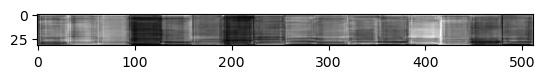

[EVAL] processed batch 0, disc_loss=0.5035849809646606 | ad_loss=1.0677225589752197, recog_loss=20.940153121948242
[EVAL] processed batch 1, disc_loss=0.5569535493850708 | ad_loss=0.9942092895507812, recog_loss=19.02054214477539
[EVAL] processed batch 2, disc_loss=0.5445265769958496 | ad_loss=1.135974407196045, recog_loss=18.033430099487305
[EVAL] processed batch 3, disc_loss=0.5950418710708618 | ad_loss=0.9780459403991699, recog_loss=21.742116928100586
[EVAL] processed batch 4, disc_loss=0.5042707920074463 | ad_loss=1.15024733543396, recog_loss=19.750946044921875
[EVAL] processed batch 5, disc_loss=0.5017977952957153 | ad_loss=1.1279505491256714, recog_loss=17.824811935424805
[EVAL] processed batch 6, disc_loss=0.5357796549797058 | ad_loss=0.9377731680870056, recog_loss=18.935625076293945
[EVAL] processed batch 7, disc_loss=0.5283970832824707 | ad_loss=1.07413649559021, recog_loss=18.849475860595703
[EVAL] processed batch 8, disc_loss=0.5730582475662231 | ad_loss=1.0532728433609009, r

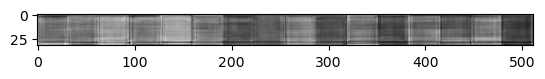

[EVAL] processed batch 0, disc_loss=0.3816384971141815 | ad_loss=1.3809096813201904, recog_loss=18.443330764770508
[EVAL] processed batch 1, disc_loss=0.40085718035697937 | ad_loss=1.3358075618743896, recog_loss=20.727954864501953
[EVAL] processed batch 2, disc_loss=0.4206012487411499 | ad_loss=1.3306795358657837, recog_loss=15.986933708190918
[EVAL] processed batch 3, disc_loss=0.3832889795303345 | ad_loss=1.411647915840149, recog_loss=20.755395889282227
[EVAL] processed batch 4, disc_loss=0.4393730163574219 | ad_loss=1.3190600872039795, recog_loss=20.280067443847656
[EVAL] processed batch 5, disc_loss=0.4425002336502075 | ad_loss=1.3150173425674438, recog_loss=17.867088317871094
[EVAL] processed batch 6, disc_loss=0.43624618649482727 | ad_loss=1.35740065574646, recog_loss=17.96396255493164
[EVAL] processed batch 7, disc_loss=0.3947775661945343 | ad_loss=1.499542474746704, recog_loss=19.675992965698242
[EVAL] processed batch 8, disc_loss=0.3740745782852173 | ad_loss=1.378218173980713,

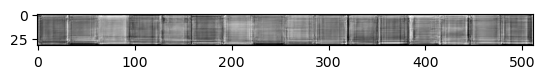

[EVAL] processed batch 0, disc_loss=0.3614519536495209 | ad_loss=1.4293944835662842, recog_loss=18.626020431518555
[EVAL] processed batch 1, disc_loss=0.3281036615371704 | ad_loss=1.3073848485946655, recog_loss=17.789886474609375
[EVAL] processed batch 2, disc_loss=0.28804120421409607 | ad_loss=1.5007741451263428, recog_loss=15.909852981567383
[EVAL] processed batch 3, disc_loss=0.33605271577835083 | ad_loss=1.436413288116455, recog_loss=19.086570739746094
[EVAL] processed batch 4, disc_loss=0.3358232378959656 | ad_loss=1.4162514209747314, recog_loss=17.122255325317383
[EVAL] processed batch 5, disc_loss=0.3640460669994354 | ad_loss=1.3577678203582764, recog_loss=16.46574592590332
[EVAL] processed batch 6, disc_loss=0.33099615573883057 | ad_loss=1.4426109790802002, recog_loss=23.120813369750977
[EVAL] processed batch 7, disc_loss=0.3271711468696594 | ad_loss=1.3867318630218506, recog_loss=20.586233139038086
[EVAL] processed batch 8, disc_loss=0.3493678569793701 | ad_loss=1.442659854888

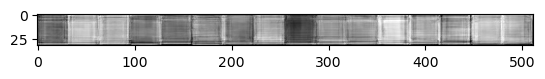

[EVAL] processed batch 0, disc_loss=0.2839324176311493 | ad_loss=1.7764723300933838, recog_loss=21.939804077148438
[EVAL] processed batch 1, disc_loss=0.28736400604248047 | ad_loss=1.5385746955871582, recog_loss=18.894821166992188
[EVAL] processed batch 2, disc_loss=0.2799850106239319 | ad_loss=1.7125513553619385, recog_loss=17.958133697509766
[EVAL] processed batch 3, disc_loss=0.26976415514945984 | ad_loss=1.5729199647903442, recog_loss=23.124027252197266
[EVAL] processed batch 4, disc_loss=0.29803407192230225 | ad_loss=1.6737005710601807, recog_loss=20.039379119873047
[EVAL] processed batch 5, disc_loss=0.24832665920257568 | ad_loss=1.818866491317749, recog_loss=19.088218688964844
[EVAL] processed batch 6, disc_loss=0.27883273363113403 | ad_loss=1.5094399452209473, recog_loss=19.063385009765625
[EVAL] processed batch 7, disc_loss=0.2694830894470215 | ad_loss=1.6648801565170288, recog_loss=19.756027221679688
[EVAL] processed batch 8, disc_loss=0.24904385209083557 | ad_loss=1.63798880

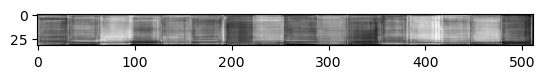

[EVAL] processed batch 0, disc_loss=0.23349958658218384 | ad_loss=1.8211324214935303, recog_loss=20.83936882019043
[EVAL] processed batch 1, disc_loss=0.2117621898651123 | ad_loss=1.8067957162857056, recog_loss=18.455373764038086
[EVAL] processed batch 2, disc_loss=0.24433189630508423 | ad_loss=1.8464887142181396, recog_loss=21.640974044799805
[EVAL] processed batch 3, disc_loss=0.227342426776886 | ad_loss=1.9455958604812622, recog_loss=18.60230827331543
[EVAL] processed batch 4, disc_loss=0.22965842485427856 | ad_loss=1.9386218786239624, recog_loss=19.86592674255371
[EVAL] processed batch 5, disc_loss=0.20426946878433228 | ad_loss=2.018996238708496, recog_loss=20.254493713378906
[EVAL] processed batch 6, disc_loss=0.23188674449920654 | ad_loss=1.8816320896148682, recog_loss=19.690082550048828
[EVAL] processed batch 7, disc_loss=0.19519509375095367 | ad_loss=1.8962281942367554, recog_loss=21.932016372680664
[EVAL] processed batch 8, disc_loss=0.21450862288475037 | ad_loss=1.94012904167

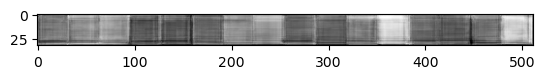

[EVAL] processed batch 0, disc_loss=0.21642397344112396 | ad_loss=2.07270884513855, recog_loss=18.196788787841797
[EVAL] processed batch 1, disc_loss=0.17362356185913086 | ad_loss=2.163790464401245, recog_loss=15.614815711975098
[EVAL] processed batch 2, disc_loss=0.1741282343864441 | ad_loss=2.168964385986328, recog_loss=19.298070907592773
[EVAL] processed batch 3, disc_loss=0.15850940346717834 | ad_loss=2.117180109024048, recog_loss=17.566967010498047
[EVAL] processed batch 4, disc_loss=0.20634782314300537 | ad_loss=2.149639129638672, recog_loss=15.104701042175293
[EVAL] processed batch 5, disc_loss=0.1611836850643158 | ad_loss=2.3397581577301025, recog_loss=17.811790466308594
[EVAL] processed batch 6, disc_loss=0.1613231599330902 | ad_loss=2.121328830718994, recog_loss=16.839136123657227
[EVAL] processed batch 7, disc_loss=0.188039168715477 | ad_loss=2.1994476318359375, recog_loss=19.24496841430664
[EVAL] processed batch 8, disc_loss=0.20140400528907776 | ad_loss=2.1542954444885254,

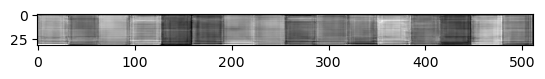

[EVAL] processed batch 0, disc_loss=0.1275659203529358 | ad_loss=2.17222261428833, recog_loss=17.733848571777344
[EVAL] processed batch 1, disc_loss=0.14165057241916656 | ad_loss=2.089433193206787, recog_loss=19.66840362548828
[EVAL] processed batch 2, disc_loss=0.13018284738063812 | ad_loss=2.1120076179504395, recog_loss=16.625431060791016
[EVAL] processed batch 3, disc_loss=0.16786928474903107 | ad_loss=2.116894245147705, recog_loss=23.59705352783203
[EVAL] processed batch 4, disc_loss=0.1261208951473236 | ad_loss=2.2165918350219727, recog_loss=17.93642234802246
[EVAL] processed batch 5, disc_loss=0.1664000153541565 | ad_loss=2.144749879837036, recog_loss=17.496456146240234
[EVAL] processed batch 6, disc_loss=0.15435835719108582 | ad_loss=2.1541595458984375, recog_loss=21.087690353393555
[EVAL] processed batch 7, disc_loss=0.1717250943183899 | ad_loss=1.9617031812667847, recog_loss=15.882827758789062
[EVAL] processed batch 8, disc_loss=0.13619203865528107 | ad_loss=2.1174449920654297

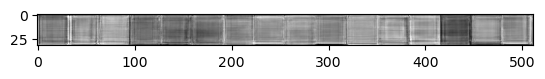

[EVAL] processed batch 0, disc_loss=0.12129925191402435 | ad_loss=2.625910758972168, recog_loss=18.393388748168945
[EVAL] processed batch 1, disc_loss=0.12308599054813385 | ad_loss=2.557394504547119, recog_loss=17.823217391967773
[EVAL] processed batch 2, disc_loss=0.12237299978733063 | ad_loss=2.602287769317627, recog_loss=18.585784912109375
[EVAL] processed batch 3, disc_loss=0.14404931664466858 | ad_loss=2.58774995803833, recog_loss=17.911619186401367
[EVAL] processed batch 4, disc_loss=0.13831143081188202 | ad_loss=2.597846269607544, recog_loss=18.11661720275879
[EVAL] processed batch 5, disc_loss=0.12059830129146576 | ad_loss=2.6166555881500244, recog_loss=18.507476806640625
[EVAL] processed batch 6, disc_loss=0.10554355382919312 | ad_loss=2.564863681793213, recog_loss=17.647584915161133
[EVAL] processed batch 7, disc_loss=0.11128579080104828 | ad_loss=2.596379518508911, recog_loss=19.20806884765625
[EVAL] processed batch 8, disc_loss=0.10586974024772644 | ad_loss=2.58993101119995

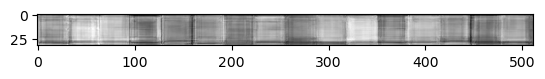

[EVAL] processed batch 0, disc_loss=0.09110274910926819 | ad_loss=2.906126022338867, recog_loss=20.593807220458984
[EVAL] processed batch 1, disc_loss=0.09702786058187485 | ad_loss=2.60044527053833, recog_loss=17.10478973388672
[EVAL] processed batch 2, disc_loss=0.1280089020729065 | ad_loss=2.8539538383483887, recog_loss=17.93241310119629
[EVAL] processed batch 3, disc_loss=0.0899776890873909 | ad_loss=2.8000316619873047, recog_loss=20.202157974243164
[EVAL] processed batch 4, disc_loss=0.09798604249954224 | ad_loss=2.8728904724121094, recog_loss=17.223079681396484
[EVAL] processed batch 5, disc_loss=0.10024282336235046 | ad_loss=2.6324844360351562, recog_loss=20.667940139770508
[EVAL] processed batch 6, disc_loss=0.07927584648132324 | ad_loss=2.8595800399780273, recog_loss=20.601572036743164
[EVAL] processed batch 7, disc_loss=0.10595020651817322 | ad_loss=2.705467939376831, recog_loss=17.541419982910156
[EVAL] processed batch 8, disc_loss=0.08762489259243011 | ad_loss=2.735671043395

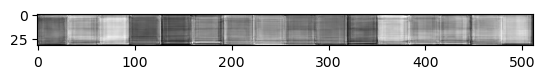

[EVAL] processed batch 0, disc_loss=0.07774685323238373 | ad_loss=2.982318878173828, recog_loss=18.03356170654297
[EVAL] processed batch 1, disc_loss=0.07664555311203003 | ad_loss=3.002498149871826, recog_loss=18.58057975769043
[EVAL] processed batch 2, disc_loss=0.07845866680145264 | ad_loss=3.0666143894195557, recog_loss=18.998966217041016
[EVAL] processed batch 3, disc_loss=0.08786075562238693 | ad_loss=3.0247273445129395, recog_loss=18.7759952545166
[EVAL] processed batch 4, disc_loss=0.07448802143335342 | ad_loss=3.1171388626098633, recog_loss=20.084938049316406
[EVAL] processed batch 5, disc_loss=0.07717575132846832 | ad_loss=3.066660165786743, recog_loss=15.954188346862793
[EVAL] processed batch 6, disc_loss=0.08195359259843826 | ad_loss=3.078547477722168, recog_loss=21.934778213500977
[EVAL] processed batch 7, disc_loss=0.09712021052837372 | ad_loss=3.099735975265503, recog_loss=18.644067764282227
[EVAL] processed batch 8, disc_loss=0.07724006474018097 | ad_loss=3.0509285926818

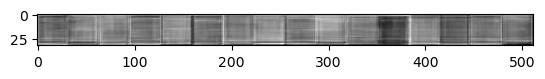

[EVAL] processed batch 0, disc_loss=0.06295450031757355 | ad_loss=2.9563372135162354, recog_loss=18.775705337524414
[EVAL] processed batch 1, disc_loss=0.06390058994293213 | ad_loss=2.9934020042419434, recog_loss=19.110294342041016
[EVAL] processed batch 2, disc_loss=0.07381060719490051 | ad_loss=3.0353317260742188, recog_loss=20.010536193847656
[EVAL] processed batch 3, disc_loss=0.06944625079631805 | ad_loss=2.8676047325134277, recog_loss=18.752323150634766
[EVAL] processed batch 4, disc_loss=0.05620025098323822 | ad_loss=3.09125018119812, recog_loss=18.001516342163086
[EVAL] processed batch 5, disc_loss=0.06213657557964325 | ad_loss=3.111455202102661, recog_loss=20.27665901184082
[EVAL] processed batch 6, disc_loss=0.08458910882472992 | ad_loss=2.961275577545166, recog_loss=17.635072708129883
[EVAL] processed batch 7, disc_loss=0.0522468239068985 | ad_loss=3.0890188217163086, recog_loss=19.592416763305664
[EVAL] processed batch 8, disc_loss=0.06801773607730865 | ad_loss=2.9167160987

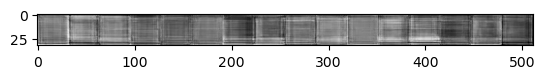

[EVAL] processed batch 0, disc_loss=0.05776052922010422 | ad_loss=3.227665424346924, recog_loss=20.30306053161621
[EVAL] processed batch 1, disc_loss=0.06548915803432465 | ad_loss=3.0701794624328613, recog_loss=18.678510665893555
[EVAL] processed batch 2, disc_loss=0.06216771528124809 | ad_loss=3.024233341217041, recog_loss=17.647966384887695
[EVAL] processed batch 3, disc_loss=0.048242706805467606 | ad_loss=3.2979378700256348, recog_loss=18.714927673339844
[EVAL] processed batch 4, disc_loss=0.042423367500305176 | ad_loss=3.33381986618042, recog_loss=21.88249397277832
[EVAL] processed batch 5, disc_loss=0.05951450765132904 | ad_loss=3.0719046592712402, recog_loss=18.512325286865234
[EVAL] processed batch 6, disc_loss=0.049083005636930466 | ad_loss=3.253368377685547, recog_loss=18.869646072387695
[EVAL] processed batch 7, disc_loss=0.045649684965610504 | ad_loss=3.182724952697754, recog_loss=22.332294464111328
[EVAL] processed batch 8, disc_loss=0.05898456647992134 | ad_loss=3.08346819

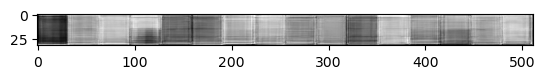

[EVAL] processed batch 0, disc_loss=0.042090460658073425 | ad_loss=3.369081497192383, recog_loss=20.97125244140625
[EVAL] processed batch 1, disc_loss=0.049051083624362946 | ad_loss=3.2790050506591797, recog_loss=16.281442642211914
[EVAL] processed batch 2, disc_loss=0.04320594295859337 | ad_loss=3.4539408683776855, recog_loss=17.68360710144043
[EVAL] processed batch 3, disc_loss=0.04848381131887436 | ad_loss=3.263378620147705, recog_loss=16.509140014648438
[EVAL] processed batch 4, disc_loss=0.0437651053071022 | ad_loss=3.226790428161621, recog_loss=17.33692741394043
[EVAL] processed batch 5, disc_loss=0.037461232393980026 | ad_loss=3.3566997051239014, recog_loss=17.793922424316406
[EVAL] processed batch 6, disc_loss=0.041501324623823166 | ad_loss=3.3026061058044434, recog_loss=22.233999252319336
[EVAL] processed batch 7, disc_loss=0.0449712909758091 | ad_loss=3.433234930038452, recog_loss=19.336206436157227
[EVAL] processed batch 8, disc_loss=0.05164077877998352 | ad_loss=3.267438888

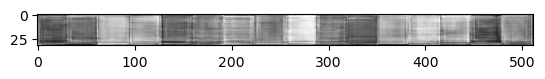

[EVAL] processed batch 0, disc_loss=0.03843042999505997 | ad_loss=3.576881170272827, recog_loss=19.525054931640625
[EVAL] processed batch 1, disc_loss=0.04013223946094513 | ad_loss=3.494539737701416, recog_loss=18.20472526550293
[EVAL] processed batch 2, disc_loss=0.03780043497681618 | ad_loss=3.552309513092041, recog_loss=15.48713493347168
[EVAL] processed batch 3, disc_loss=0.03613203763961792 | ad_loss=3.428776979446411, recog_loss=18.293615341186523
[EVAL] processed batch 4, disc_loss=0.0403638556599617 | ad_loss=3.333627700805664, recog_loss=21.440250396728516
[EVAL] processed batch 5, disc_loss=0.03733861446380615 | ad_loss=3.609391689300537, recog_loss=19.935741424560547
[EVAL] processed batch 6, disc_loss=0.035859573632478714 | ad_loss=3.437591314315796, recog_loss=21.844186782836914
[EVAL] processed batch 7, disc_loss=0.04107034578919411 | ad_loss=3.4136886596679688, recog_loss=17.76348304748535
[EVAL] processed batch 8, disc_loss=0.04165830463171005 | ad_loss=3.60306835174560

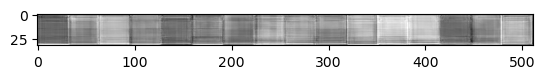

[EVAL] processed batch 0, disc_loss=0.03517098352313042 | ad_loss=3.553999662399292, recog_loss=18.61667251586914
[EVAL] processed batch 1, disc_loss=0.04022282734513283 | ad_loss=3.3809566497802734, recog_loss=16.97336769104004
[EVAL] processed batch 2, disc_loss=0.033895403146743774 | ad_loss=3.460658550262451, recog_loss=15.739903450012207
[EVAL] processed batch 3, disc_loss=0.03652073070406914 | ad_loss=3.346797466278076, recog_loss=17.709243774414062
[EVAL] processed batch 4, disc_loss=0.02839844487607479 | ad_loss=3.646757125854492, recog_loss=17.85295295715332
[EVAL] processed batch 5, disc_loss=0.028747504577040672 | ad_loss=3.551607131958008, recog_loss=19.478179931640625
[EVAL] processed batch 6, disc_loss=0.030520211905241013 | ad_loss=3.6455535888671875, recog_loss=18.482555389404297
[EVAL] processed batch 7, disc_loss=0.03160915523767471 | ad_loss=3.5339772701263428, recog_loss=16.392560958862305
[EVAL] processed batch 8, disc_loss=0.03727734461426735 | ad_loss=3.513155937

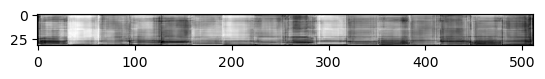

[EVAL] processed batch 0, disc_loss=0.02813316136598587 | ad_loss=3.8885304927825928, recog_loss=18.608558654785156
[EVAL] processed batch 1, disc_loss=0.025497494265437126 | ad_loss=3.995387554168701, recog_loss=20.91042709350586
[EVAL] processed batch 2, disc_loss=0.029130876064300537 | ad_loss=3.8556082248687744, recog_loss=16.731754302978516
[EVAL] processed batch 3, disc_loss=0.029225245118141174 | ad_loss=3.7924246788024902, recog_loss=17.985918045043945
[EVAL] processed batch 4, disc_loss=0.029798902571201324 | ad_loss=3.720043659210205, recog_loss=19.293394088745117
[EVAL] processed batch 5, disc_loss=0.032022859901189804 | ad_loss=3.7936744689941406, recog_loss=17.271596908569336
[EVAL] processed batch 6, disc_loss=0.031458765268325806 | ad_loss=3.806724786758423, recog_loss=19.583297729492188
[EVAL] processed batch 7, disc_loss=0.029151681810617447 | ad_loss=3.9454996585845947, recog_loss=19.08258056640625
[EVAL] processed batch 8, disc_loss=0.03047337755560875 | ad_loss=3.80

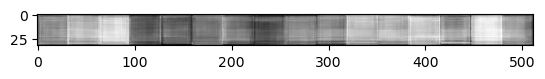

[EVAL] processed batch 0, disc_loss=0.02154095098376274 | ad_loss=4.096949577331543, recog_loss=18.360389709472656
[EVAL] processed batch 1, disc_loss=0.020242758095264435 | ad_loss=4.1001458168029785, recog_loss=19.836103439331055
[EVAL] processed batch 2, disc_loss=0.023930050432682037 | ad_loss=4.249868392944336, recog_loss=20.226064682006836
[EVAL] processed batch 3, disc_loss=0.021029435098171234 | ad_loss=3.9864468574523926, recog_loss=18.180465698242188
[EVAL] processed batch 4, disc_loss=0.022042319178581238 | ad_loss=4.155055522918701, recog_loss=19.518850326538086
[EVAL] processed batch 5, disc_loss=0.02660123072564602 | ad_loss=3.9911563396453857, recog_loss=20.48652458190918
[EVAL] processed batch 6, disc_loss=0.026396241039037704 | ad_loss=4.06163215637207, recog_loss=14.926776885986328
[EVAL] processed batch 7, disc_loss=0.020856056362390518 | ad_loss=4.125880241394043, recog_loss=17.660728454589844
[EVAL] processed batch 8, disc_loss=0.02131856232881546 | ad_loss=4.14581

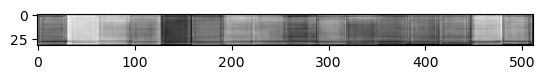

[EVAL] processed batch 0, disc_loss=0.018614670261740685 | ad_loss=4.3177409172058105, recog_loss=18.455411911010742
[EVAL] processed batch 1, disc_loss=0.02291206084191799 | ad_loss=4.248862266540527, recog_loss=20.35869789123535
[EVAL] processed batch 2, disc_loss=0.02627803385257721 | ad_loss=4.091980934143066, recog_loss=15.767950057983398
[EVAL] processed batch 3, disc_loss=0.02180773764848709 | ad_loss=4.204110145568848, recog_loss=18.70481300354004
[EVAL] processed batch 4, disc_loss=0.029194766655564308 | ad_loss=4.260825157165527, recog_loss=18.39818572998047
[EVAL] processed batch 5, disc_loss=0.023500297218561172 | ad_loss=4.280215263366699, recog_loss=17.529062271118164
[EVAL] processed batch 6, disc_loss=0.02185656875371933 | ad_loss=4.443889617919922, recog_loss=18.30331039428711
[EVAL] processed batch 7, disc_loss=0.02053651586174965 | ad_loss=4.196805000305176, recog_loss=15.5156888961792
[EVAL] processed batch 8, disc_loss=0.016880039125680923 | ad_loss=4.3461446762084

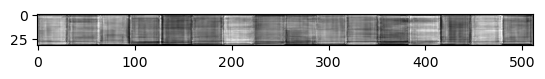

[EVAL] processed batch 0, disc_loss=0.01662466488778591 | ad_loss=4.183806419372559, recog_loss=17.156625747680664
[EVAL] processed batch 1, disc_loss=0.02076488733291626 | ad_loss=4.220639228820801, recog_loss=16.675397872924805
[EVAL] processed batch 2, disc_loss=0.018712297081947327 | ad_loss=4.255511283874512, recog_loss=16.920400619506836
[EVAL] processed batch 3, disc_loss=0.018261190503835678 | ad_loss=4.179014205932617, recog_loss=18.750492095947266
[EVAL] processed batch 4, disc_loss=0.02370830439031124 | ad_loss=4.23473596572876, recog_loss=16.709789276123047
[EVAL] processed batch 5, disc_loss=0.017720678821206093 | ad_loss=4.135759353637695, recog_loss=17.70085906982422
[EVAL] processed batch 6, disc_loss=0.01824195496737957 | ad_loss=4.121498107910156, recog_loss=16.201305389404297
[EVAL] processed batch 7, disc_loss=0.017106186598539352 | ad_loss=4.157222747802734, recog_loss=17.82080078125
[EVAL] processed batch 8, disc_loss=0.024810001254081726 | ad_loss=4.2389144897460

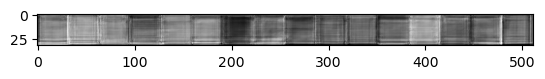

[EVAL] processed batch 0, disc_loss=0.014187652617692947 | ad_loss=4.670691967010498, recog_loss=19.089025497436523
[EVAL] processed batch 1, disc_loss=0.017991285771131516 | ad_loss=4.493505477905273, recog_loss=17.184022903442383
[EVAL] processed batch 2, disc_loss=0.019998887553811073 | ad_loss=4.664947032928467, recog_loss=21.073097229003906
[EVAL] processed batch 3, disc_loss=0.01568938046693802 | ad_loss=4.598775863647461, recog_loss=16.632362365722656
[EVAL] processed batch 4, disc_loss=0.018410857766866684 | ad_loss=4.572888374328613, recog_loss=17.645225524902344
[EVAL] processed batch 5, disc_loss=0.014296635054051876 | ad_loss=4.754890441894531, recog_loss=16.605998992919922
[EVAL] processed batch 6, disc_loss=0.016592608764767647 | ad_loss=4.557490348815918, recog_loss=16.890727996826172
[EVAL] processed batch 7, disc_loss=0.015907369554042816 | ad_loss=4.623410224914551, recog_loss=17.400251388549805
[EVAL] processed batch 8, disc_loss=0.01323157548904419 | ad_loss=4.57419

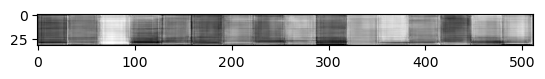

[EVAL] processed batch 0, disc_loss=0.014470508322119713 | ad_loss=4.95447301864624, recog_loss=15.1654634475708
[EVAL] processed batch 1, disc_loss=0.015739189460873604 | ad_loss=4.730953693389893, recog_loss=16.544164657592773
[EVAL] processed batch 2, disc_loss=0.019658606499433517 | ad_loss=4.94629430770874, recog_loss=18.563817977905273
[EVAL] processed batch 3, disc_loss=0.015205299481749535 | ad_loss=4.842339992523193, recog_loss=14.802827835083008
[EVAL] processed batch 4, disc_loss=0.014869257807731628 | ad_loss=4.744372367858887, recog_loss=20.0709171295166
[EVAL] processed batch 5, disc_loss=0.014400570653378963 | ad_loss=4.727199554443359, recog_loss=17.289649963378906
[EVAL] processed batch 6, disc_loss=0.017172453925013542 | ad_loss=4.828695297241211, recog_loss=16.899707794189453
[EVAL] processed batch 7, disc_loss=0.01531006395816803 | ad_loss=4.742936134338379, recog_loss=19.289756774902344
[EVAL] processed batch 8, disc_loss=0.01858881115913391 | ad_loss=4.64987707138

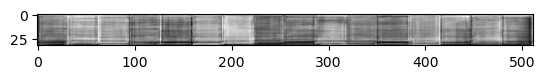

[EVAL] processed batch 0, disc_loss=0.01727997697889805 | ad_loss=4.667194366455078, recog_loss=14.563308715820312
[EVAL] processed batch 1, disc_loss=0.013969626277685165 | ad_loss=4.6389899253845215, recog_loss=17.3395938873291
[EVAL] processed batch 2, disc_loss=0.017985425889492035 | ad_loss=4.706661224365234, recog_loss=19.607358932495117
[EVAL] processed batch 3, disc_loss=0.013767119497060776 | ad_loss=4.422119617462158, recog_loss=16.32195472717285
[EVAL] processed batch 4, disc_loss=0.012740064412355423 | ad_loss=4.555663108825684, recog_loss=19.638811111450195
[EVAL] processed batch 5, disc_loss=0.012850447557866573 | ad_loss=4.6532063484191895, recog_loss=15.967439651489258
[EVAL] processed batch 6, disc_loss=0.010997697710990906 | ad_loss=4.70505428314209, recog_loss=19.462116241455078
[EVAL] processed batch 7, disc_loss=0.014730457216501236 | ad_loss=4.721563816070557, recog_loss=18.46019744873047
[EVAL] processed batch 8, disc_loss=0.02020411565899849 | ad_loss=4.47951269

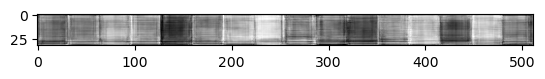

[EVAL] processed batch 0, disc_loss=0.015005874447524548 | ad_loss=4.509036064147949, recog_loss=15.55046272277832
[EVAL] processed batch 1, disc_loss=0.014251071959733963 | ad_loss=4.664299011230469, recog_loss=17.842063903808594
[EVAL] processed batch 2, disc_loss=0.014803808182477951 | ad_loss=4.417339324951172, recog_loss=20.323551177978516
[EVAL] processed batch 3, disc_loss=0.009907838888466358 | ad_loss=4.85144567489624, recog_loss=20.324478149414062
[EVAL] processed batch 4, disc_loss=0.014692461118102074 | ad_loss=4.38613224029541, recog_loss=12.739185333251953
[EVAL] processed batch 5, disc_loss=0.013104453682899475 | ad_loss=4.5531229972839355, recog_loss=16.033912658691406
[EVAL] processed batch 6, disc_loss=0.011486802250146866 | ad_loss=4.6111650466918945, recog_loss=18.05203628540039
[EVAL] processed batch 7, disc_loss=0.011647828854620457 | ad_loss=4.677883148193359, recog_loss=17.865020751953125
[EVAL] processed batch 8, disc_loss=0.014048147946596146 | ad_loss=4.53360

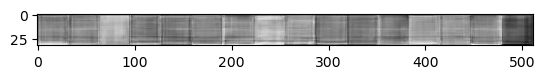

[EVAL] processed batch 0, disc_loss=0.010648195631802082 | ad_loss=4.9716901779174805, recog_loss=17.397003173828125
[EVAL] processed batch 1, disc_loss=0.015835799276828766 | ad_loss=4.717634201049805, recog_loss=19.6768798828125
[EVAL] processed batch 2, disc_loss=0.014221247285604477 | ad_loss=4.710286617279053, recog_loss=16.44438362121582
[EVAL] processed batch 3, disc_loss=0.014549128711223602 | ad_loss=4.821948051452637, recog_loss=14.577864646911621
[EVAL] processed batch 4, disc_loss=0.01204249169677496 | ad_loss=4.991156101226807, recog_loss=19.62433433532715
[EVAL] processed batch 5, disc_loss=0.010087482631206512 | ad_loss=4.88907527923584, recog_loss=18.516138076782227
[EVAL] processed batch 6, disc_loss=0.010732920840382576 | ad_loss=5.021989822387695, recog_loss=16.80108070373535
[EVAL] processed batch 7, disc_loss=0.014465345069766045 | ad_loss=4.8293681144714355, recog_loss=19.728452682495117
[EVAL] processed batch 8, disc_loss=0.012471402063965797 | ad_loss=4.79894542

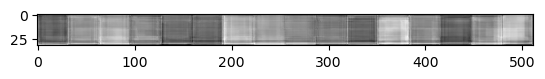

[EVAL] processed batch 0, disc_loss=0.016265779733657837 | ad_loss=4.953357219696045, recog_loss=19.236413955688477
[EVAL] processed batch 1, disc_loss=0.01053026132285595 | ad_loss=4.9259467124938965, recog_loss=16.63703727722168
[EVAL] processed batch 2, disc_loss=0.011585323140025139 | ad_loss=4.836803436279297, recog_loss=19.050004959106445
[EVAL] processed batch 3, disc_loss=0.010146872140467167 | ad_loss=4.831155300140381, recog_loss=18.132890701293945
[EVAL] processed batch 4, disc_loss=0.01426929421722889 | ad_loss=4.8109846115112305, recog_loss=16.205522537231445
[EVAL] processed batch 5, disc_loss=0.010491480119526386 | ad_loss=5.098559379577637, recog_loss=17.97032928466797
[EVAL] processed batch 6, disc_loss=0.012886809185147285 | ad_loss=4.961321830749512, recog_loss=16.10468864440918
[EVAL] processed batch 7, disc_loss=0.01240448746830225 | ad_loss=4.7458038330078125, recog_loss=18.843196868896484
[EVAL] processed batch 8, disc_loss=0.01365502830594778 | ad_loss=4.9884376

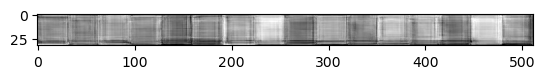

[EVAL] processed batch 0, disc_loss=0.012149580754339695 | ad_loss=4.739638328552246, recog_loss=16.546630859375
[EVAL] processed batch 1, disc_loss=0.010644042864441872 | ad_loss=4.738478183746338, recog_loss=18.823829650878906
[EVAL] processed batch 2, disc_loss=0.009999698027968407 | ad_loss=4.746921539306641, recog_loss=16.523841857910156
[EVAL] processed batch 3, disc_loss=0.009904617443680763 | ad_loss=4.851535797119141, recog_loss=16.294004440307617
[EVAL] processed batch 4, disc_loss=0.010498272255063057 | ad_loss=4.665174961090088, recog_loss=18.291717529296875
[EVAL] processed batch 5, disc_loss=0.011314719915390015 | ad_loss=4.797274589538574, recog_loss=18.12836456298828
[EVAL] processed batch 6, disc_loss=0.015610466711223125 | ad_loss=4.602893352508545, recog_loss=16.18160057067871
[EVAL] processed batch 7, disc_loss=0.011367075145244598 | ad_loss=4.721453666687012, recog_loss=16.362247467041016
[EVAL] processed batch 8, disc_loss=0.012035658583045006 | ad_loss=4.61669063

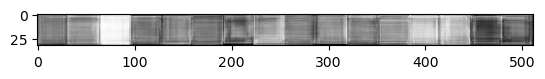

[EVAL] processed batch 0, disc_loss=0.010193204507231712 | ad_loss=4.8011956214904785, recog_loss=16.523101806640625
[EVAL] processed batch 1, disc_loss=0.011011000722646713 | ad_loss=4.51888370513916, recog_loss=17.233848571777344
[EVAL] processed batch 2, disc_loss=0.009833176620304585 | ad_loss=4.790302276611328, recog_loss=19.680797576904297
[EVAL] processed batch 3, disc_loss=0.012241402640938759 | ad_loss=4.642370223999023, recog_loss=18.60617446899414
[EVAL] processed batch 4, disc_loss=0.010256104171276093 | ad_loss=4.7150559425354, recog_loss=17.71062660217285
[EVAL] processed batch 5, disc_loss=0.009694267064332962 | ad_loss=4.6892266273498535, recog_loss=18.394699096679688
[EVAL] processed batch 6, disc_loss=0.015602275729179382 | ad_loss=4.520901203155518, recog_loss=15.72658634185791
[EVAL] processed batch 7, disc_loss=0.008893497288227081 | ad_loss=4.752348899841309, recog_loss=17.44428062438965
[EVAL] processed batch 8, disc_loss=0.010088393464684486 | ad_loss=4.78891563

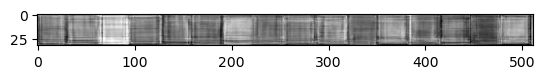

[EVAL] processed batch 0, disc_loss=0.010259261354804039 | ad_loss=4.742330074310303, recog_loss=17.71681785583496
[EVAL] processed batch 1, disc_loss=0.013775723986327648 | ad_loss=4.8308916091918945, recog_loss=17.450592041015625
[EVAL] processed batch 2, disc_loss=0.011459232307970524 | ad_loss=4.860113143920898, recog_loss=16.185176849365234
[EVAL] processed batch 3, disc_loss=0.012033538892865181 | ad_loss=4.826602935791016, recog_loss=16.031761169433594
[EVAL] processed batch 4, disc_loss=0.014036520384252071 | ad_loss=4.583527565002441, recog_loss=16.828937530517578
[EVAL] processed batch 5, disc_loss=0.009781824424862862 | ad_loss=4.846514701843262, recog_loss=15.578705787658691
[EVAL] processed batch 6, disc_loss=0.009245382621884346 | ad_loss=4.83668327331543, recog_loss=18.920873641967773
[EVAL] processed batch 7, disc_loss=0.010741423815488815 | ad_loss=4.686923980712891, recog_loss=14.61156177520752
[EVAL] processed batch 8, disc_loss=0.010144038125872612 | ad_loss=4.84352

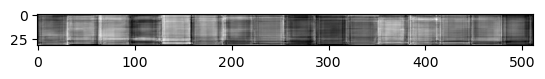

[EVAL] processed batch 0, disc_loss=0.010808853432536125 | ad_loss=4.695295333862305, recog_loss=15.472850799560547
[EVAL] processed batch 1, disc_loss=0.009726697579026222 | ad_loss=4.63355827331543, recog_loss=17.02379035949707
[EVAL] processed batch 2, disc_loss=0.011260926723480225 | ad_loss=4.666955947875977, recog_loss=19.241531372070312
[EVAL] processed batch 3, disc_loss=0.011480417102575302 | ad_loss=4.585969924926758, recog_loss=16.75971031188965
[EVAL] processed batch 4, disc_loss=0.010753246024250984 | ad_loss=4.714794158935547, recog_loss=19.271699905395508
[EVAL] processed batch 5, disc_loss=0.009773319587111473 | ad_loss=4.6367363929748535, recog_loss=19.48350715637207
[EVAL] processed batch 6, disc_loss=0.01046445406973362 | ad_loss=4.769864082336426, recog_loss=17.018903732299805
[EVAL] processed batch 7, disc_loss=0.010221729055047035 | ad_loss=4.691571235656738, recog_loss=15.98989486694336
[EVAL] processed batch 8, disc_loss=0.010492771863937378 | ad_loss=4.64451980

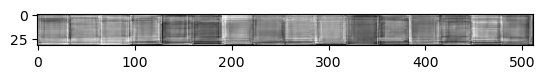

[EVAL] processed batch 0, disc_loss=0.011706268414855003 | ad_loss=4.785867214202881, recog_loss=20.195531845092773
[EVAL] processed batch 1, disc_loss=0.0095632653683424 | ad_loss=4.691357612609863, recog_loss=17.780345916748047
[EVAL] processed batch 2, disc_loss=0.010705512017011642 | ad_loss=4.5131683349609375, recog_loss=17.43634796142578
[EVAL] processed batch 3, disc_loss=0.00868433341383934 | ad_loss=4.788378715515137, recog_loss=18.438154220581055
[EVAL] processed batch 4, disc_loss=0.015193442814052105 | ad_loss=4.551814556121826, recog_loss=18.627059936523438
[EVAL] processed batch 5, disc_loss=0.010890699923038483 | ad_loss=4.79655122756958, recog_loss=18.453399658203125
[EVAL] processed batch 6, disc_loss=0.011241882108151913 | ad_loss=4.585721015930176, recog_loss=19.107484817504883
[EVAL] processed batch 7, disc_loss=0.012521153315901756 | ad_loss=4.805668830871582, recog_loss=17.42136001586914
[EVAL] processed batch 8, disc_loss=0.011443601921200752 | ad_loss=4.85926723

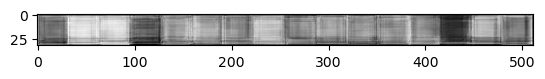

[EVAL] processed batch 0, disc_loss=0.012152774259448051 | ad_loss=4.9244890213012695, recog_loss=16.193124771118164
[EVAL] processed batch 1, disc_loss=0.0102870874106884 | ad_loss=4.726131439208984, recog_loss=18.576454162597656
[EVAL] processed batch 2, disc_loss=0.014576015993952751 | ad_loss=4.783844947814941, recog_loss=17.846134185791016
[EVAL] processed batch 3, disc_loss=0.00861252099275589 | ad_loss=4.8943681716918945, recog_loss=17.580961227416992
[EVAL] processed batch 4, disc_loss=0.010067639872431755 | ad_loss=4.841771125793457, recog_loss=19.400299072265625
[EVAL] processed batch 5, disc_loss=0.013770733028650284 | ad_loss=4.744541168212891, recog_loss=15.933188438415527
[EVAL] processed batch 6, disc_loss=0.010146820917725563 | ad_loss=4.904355049133301, recog_loss=18.810091018676758
[EVAL] processed batch 7, disc_loss=0.009864592924714088 | ad_loss=4.882922172546387, recog_loss=17.696496963500977
[EVAL] processed batch 8, disc_loss=0.01353240106254816 | ad_loss=4.70397

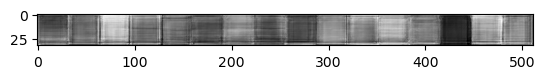

[EVAL] processed batch 0, disc_loss=0.010416517034173012 | ad_loss=4.467389106750488, recog_loss=15.831452369689941
[EVAL] processed batch 1, disc_loss=0.01106471661478281 | ad_loss=4.499336242675781, recog_loss=15.688542366027832
[EVAL] processed batch 2, disc_loss=0.012520245276391506 | ad_loss=4.378172874450684, recog_loss=17.199899673461914
[EVAL] processed batch 3, disc_loss=0.01107368990778923 | ad_loss=4.7158942222595215, recog_loss=21.425458908081055
[EVAL] processed batch 4, disc_loss=0.011689132079482079 | ad_loss=4.4630045890808105, recog_loss=18.11037254333496
[EVAL] processed batch 5, disc_loss=0.010726523585617542 | ad_loss=4.445972442626953, recog_loss=14.342438697814941
[EVAL] processed batch 6, disc_loss=0.009810092858970165 | ad_loss=4.650945663452148, recog_loss=17.2202205657959
[EVAL] processed batch 7, disc_loss=0.011580566875636578 | ad_loss=4.548196792602539, recog_loss=17.269927978515625
[EVAL] processed batch 8, disc_loss=0.013854162767529488 | ad_loss=4.320408

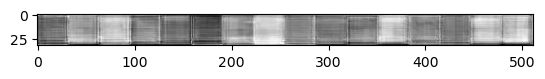

[EVAL] processed batch 0, disc_loss=0.0138287004083395 | ad_loss=4.562714576721191, recog_loss=15.535015106201172
[EVAL] processed batch 1, disc_loss=0.011244619265198708 | ad_loss=4.609524250030518, recog_loss=19.39706802368164
[EVAL] processed batch 2, disc_loss=0.010975712910294533 | ad_loss=4.547497749328613, recog_loss=19.82279396057129
[EVAL] processed batch 3, disc_loss=0.010545831173658371 | ad_loss=4.490649223327637, recog_loss=18.188922882080078
[EVAL] processed batch 4, disc_loss=0.008654667064547539 | ad_loss=4.670261859893799, recog_loss=13.423599243164062
[EVAL] processed batch 5, disc_loss=0.009017055854201317 | ad_loss=4.645908355712891, recog_loss=16.973730087280273
[EVAL] processed batch 6, disc_loss=0.011405529454350471 | ad_loss=4.613422870635986, recog_loss=17.782869338989258
[EVAL] processed batch 7, disc_loss=0.012343212962150574 | ad_loss=4.495651721954346, recog_loss=16.38960838317871
[EVAL] processed batch 8, disc_loss=0.011171837337315083 | ad_loss=4.53229808

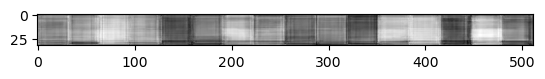

[EVAL] processed batch 0, disc_loss=0.011384207755327225 | ad_loss=4.964441776275635, recog_loss=16.27029037475586
[EVAL] processed batch 1, disc_loss=0.01198375690728426 | ad_loss=4.893404960632324, recog_loss=19.165420532226562
[EVAL] processed batch 2, disc_loss=0.012240183539688587 | ad_loss=4.553799629211426, recog_loss=17.99738311767578
[EVAL] processed batch 3, disc_loss=0.012401457875967026 | ad_loss=4.801583290100098, recog_loss=17.091081619262695
[EVAL] processed batch 4, disc_loss=0.010440235957503319 | ad_loss=4.794313907623291, recog_loss=20.642345428466797
[EVAL] processed batch 5, disc_loss=0.011515619233250618 | ad_loss=4.502981185913086, recog_loss=19.522214889526367
[EVAL] processed batch 6, disc_loss=0.010245881043374538 | ad_loss=4.671401023864746, recog_loss=15.372486114501953
[EVAL] processed batch 7, disc_loss=0.01044400967657566 | ad_loss=4.712062358856201, recog_loss=18.760473251342773
[EVAL] processed batch 8, disc_loss=0.009691338986158371 | ad_loss=4.9867000

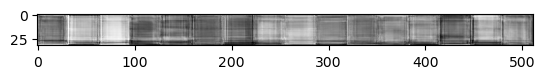

[EVAL] processed batch 0, disc_loss=0.010547757148742676 | ad_loss=4.489689826965332, recog_loss=19.084238052368164
[EVAL] processed batch 1, disc_loss=0.01048329472541809 | ad_loss=4.522166728973389, recog_loss=19.136186599731445
[EVAL] processed batch 2, disc_loss=0.009215371683239937 | ad_loss=4.476666450500488, recog_loss=15.630392074584961
[EVAL] processed batch 3, disc_loss=0.011060945689678192 | ad_loss=4.485198497772217, recog_loss=14.3816499710083
[EVAL] processed batch 4, disc_loss=0.010505042970180511 | ad_loss=4.513969421386719, recog_loss=20.373247146606445
[EVAL] processed batch 5, disc_loss=0.010545419529080391 | ad_loss=4.571173191070557, recog_loss=15.194961547851562
[EVAL] processed batch 6, disc_loss=0.01027817651629448 | ad_loss=4.429982662200928, recog_loss=18.527605056762695
[EVAL] processed batch 7, disc_loss=0.009584162384271622 | ad_loss=4.5045857429504395, recog_loss=17.957481384277344
[EVAL] processed batch 8, disc_loss=0.010211044922471046 | ad_loss=4.557896

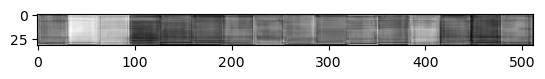

[EVAL] processed batch 0, disc_loss=0.012627426534891129 | ad_loss=4.424429416656494, recog_loss=15.761954307556152
[EVAL] processed batch 1, disc_loss=0.009537911042571068 | ad_loss=4.683699607849121, recog_loss=19.494752883911133
[EVAL] processed batch 2, disc_loss=0.010923514142632484 | ad_loss=4.77126407623291, recog_loss=18.034042358398438
[EVAL] processed batch 3, disc_loss=0.009727491065859795 | ad_loss=4.566534042358398, recog_loss=19.553871154785156
[EVAL] processed batch 4, disc_loss=0.00946833286434412 | ad_loss=4.639895439147949, recog_loss=17.313392639160156
[EVAL] processed batch 5, disc_loss=0.01172703318297863 | ad_loss=4.775391578674316, recog_loss=15.09045696258545
[EVAL] processed batch 6, disc_loss=0.011203988455235958 | ad_loss=4.70325231552124, recog_loss=17.662445068359375
[EVAL] processed batch 7, disc_loss=0.013203730806708336 | ad_loss=4.509471416473389, recog_loss=15.4296293258667
[EVAL] processed batch 8, disc_loss=0.007494520395994186 | ad_loss=4.8186531066

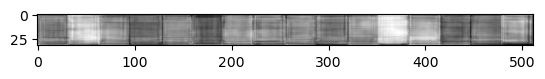

[EVAL] processed batch 0, disc_loss=0.009397833608090878 | ad_loss=4.83090877532959, recog_loss=16.22754669189453
[EVAL] processed batch 1, disc_loss=0.010100968182086945 | ad_loss=4.718695640563965, recog_loss=17.34547233581543
[EVAL] processed batch 2, disc_loss=0.013051982969045639 | ad_loss=4.354843616485596, recog_loss=15.139364242553711
[EVAL] processed batch 3, disc_loss=0.01134954858571291 | ad_loss=4.707669258117676, recog_loss=15.882871627807617
[EVAL] processed batch 4, disc_loss=0.010834460146725178 | ad_loss=4.421106338500977, recog_loss=15.826067924499512
[EVAL] processed batch 5, disc_loss=0.009928008541464806 | ad_loss=4.650766372680664, recog_loss=17.565433502197266
[EVAL] processed batch 6, disc_loss=0.011890588328242302 | ad_loss=4.565998077392578, recog_loss=15.09765911102295
[EVAL] processed batch 7, disc_loss=0.011434029787778854 | ad_loss=4.543567657470703, recog_loss=15.838116645812988
[EVAL] processed batch 8, disc_loss=0.009489394724369049 | ad_loss=4.55321693

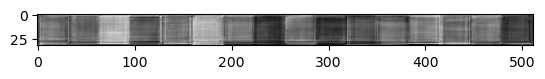

[EVAL] processed batch 0, disc_loss=0.010083243250846863 | ad_loss=4.839783191680908, recog_loss=17.910499572753906
[EVAL] processed batch 1, disc_loss=0.009874091483652592 | ad_loss=4.79669189453125, recog_loss=13.717231750488281
[EVAL] processed batch 2, disc_loss=0.011333227157592773 | ad_loss=4.672822952270508, recog_loss=18.31047821044922
[EVAL] processed batch 3, disc_loss=0.00953250378370285 | ad_loss=4.906060218811035, recog_loss=17.322832107543945
[EVAL] processed batch 4, disc_loss=0.011086918413639069 | ad_loss=4.66977596282959, recog_loss=18.116268157958984
[EVAL] processed batch 5, disc_loss=0.01165381632745266 | ad_loss=4.812599182128906, recog_loss=15.88034725189209
[EVAL] processed batch 6, disc_loss=0.010911531746387482 | ad_loss=4.62103271484375, recog_loss=20.116445541381836
[EVAL] processed batch 7, disc_loss=0.009091350249946117 | ad_loss=4.863570213317871, recog_loss=17.254987716674805
[EVAL] processed batch 8, disc_loss=0.011639588512480259 | ad_loss=4.7461986541

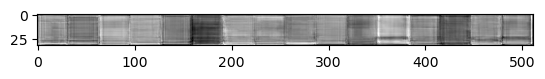

[EVAL] processed batch 0, disc_loss=0.010785632766783237 | ad_loss=4.8221049308776855, recog_loss=19.924182891845703
[EVAL] processed batch 1, disc_loss=0.009159423410892487 | ad_loss=4.87374210357666, recog_loss=16.315683364868164
[EVAL] processed batch 2, disc_loss=0.009678494185209274 | ad_loss=4.7927703857421875, recog_loss=16.229326248168945
[EVAL] processed batch 3, disc_loss=0.01203892845660448 | ad_loss=4.646281719207764, recog_loss=19.71286392211914
[EVAL] processed batch 4, disc_loss=0.009073713794350624 | ad_loss=4.759833335876465, recog_loss=17.931438446044922
[EVAL] processed batch 5, disc_loss=0.010146690532565117 | ad_loss=4.658780097961426, recog_loss=17.366004943847656
[EVAL] processed batch 6, disc_loss=0.010724910534918308 | ad_loss=4.782202243804932, recog_loss=15.29825210571289
[EVAL] processed batch 7, disc_loss=0.010705532506108284 | ad_loss=4.809135437011719, recog_loss=17.954004287719727
[EVAL] processed batch 8, disc_loss=0.01120918057858944 | ad_loss=4.756510

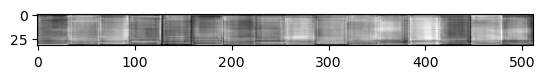

[EVAL] processed batch 0, disc_loss=0.008099871687591076 | ad_loss=5.111577033996582, recog_loss=16.594289779663086
[EVAL] processed batch 1, disc_loss=0.014481672085821629 | ad_loss=4.98578405380249, recog_loss=18.188236236572266
[EVAL] processed batch 2, disc_loss=0.012714439071714878 | ad_loss=5.109628677368164, recog_loss=16.9771671295166
[EVAL] processed batch 3, disc_loss=0.012273897416889668 | ad_loss=4.825222969055176, recog_loss=15.395589828491211
[EVAL] processed batch 4, disc_loss=0.008865678682923317 | ad_loss=5.000231742858887, recog_loss=14.292234420776367
[EVAL] processed batch 5, disc_loss=0.010707447305321693 | ad_loss=4.895915985107422, recog_loss=16.87550926208496
[EVAL] processed batch 6, disc_loss=0.01075527910143137 | ad_loss=5.096710205078125, recog_loss=17.212358474731445
[EVAL] processed batch 7, disc_loss=0.010972525924444199 | ad_loss=5.07733154296875, recog_loss=16.035409927368164
[EVAL] processed batch 8, disc_loss=0.009095631539821625 | ad_loss=5.129392623

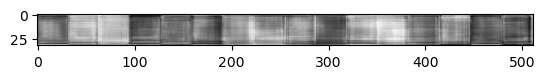

[EVAL] processed batch 0, disc_loss=0.011722736060619354 | ad_loss=4.962642192840576, recog_loss=16.536869049072266
[EVAL] processed batch 1, disc_loss=0.016249366104602814 | ad_loss=4.733809471130371, recog_loss=18.250967025756836
[EVAL] processed batch 2, disc_loss=0.012471705675125122 | ad_loss=4.737494945526123, recog_loss=15.170347213745117
[EVAL] processed batch 3, disc_loss=0.011415811255574226 | ad_loss=4.679370880126953, recog_loss=15.620119094848633
[EVAL] processed batch 4, disc_loss=0.01154262199997902 | ad_loss=4.537670135498047, recog_loss=14.5819091796875
[EVAL] processed batch 5, disc_loss=0.009077945724129677 | ad_loss=4.968585968017578, recog_loss=15.158699989318848
[EVAL] processed batch 6, disc_loss=0.010987905785441399 | ad_loss=4.818617820739746, recog_loss=17.40690040588379
[EVAL] processed batch 7, disc_loss=0.013066240586340427 | ad_loss=4.82478666305542, recog_loss=16.08115577697754
[EVAL] processed batch 8, disc_loss=0.009318104013800621 | ad_loss=4.837588310

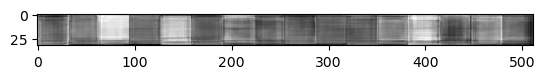

[EVAL] processed batch 0, disc_loss=0.011549139395356178 | ad_loss=4.706674575805664, recog_loss=17.162023544311523
[EVAL] processed batch 1, disc_loss=0.01081742811948061 | ad_loss=4.782167434692383, recog_loss=15.808355331420898
[EVAL] processed batch 2, disc_loss=0.011440666392445564 | ad_loss=4.743252754211426, recog_loss=18.480039596557617
[EVAL] processed batch 3, disc_loss=0.009797874838113785 | ad_loss=4.648679733276367, recog_loss=14.969005584716797
[EVAL] processed batch 4, disc_loss=0.012951398268342018 | ad_loss=4.779109954833984, recog_loss=20.243728637695312
[EVAL] processed batch 5, disc_loss=0.011241224594414234 | ad_loss=4.560145378112793, recog_loss=17.671201705932617
[EVAL] processed batch 6, disc_loss=0.011879200115799904 | ad_loss=4.671179294586182, recog_loss=18.36094093322754
[EVAL] processed batch 7, disc_loss=0.010986830107867718 | ad_loss=4.716444969177246, recog_loss=15.323369026184082
[EVAL] processed batch 8, disc_loss=0.009449794888496399 | ad_loss=4.82481

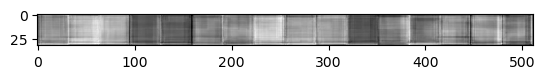

[EVAL] processed batch 0, disc_loss=0.010513093322515488 | ad_loss=4.671907424926758, recog_loss=16.988643646240234
[EVAL] processed batch 1, disc_loss=0.009491520933806896 | ad_loss=4.801023483276367, recog_loss=17.458356857299805
[EVAL] processed batch 2, disc_loss=0.010930663906037807 | ad_loss=4.503635406494141, recog_loss=17.392398834228516
[EVAL] processed batch 3, disc_loss=0.010524317622184753 | ad_loss=4.735432147979736, recog_loss=15.787216186523438
[EVAL] processed batch 4, disc_loss=0.012103020213544369 | ad_loss=4.55247688293457, recog_loss=18.60685157775879
[EVAL] processed batch 5, disc_loss=0.009707454591989517 | ad_loss=4.790771484375, recog_loss=16.060897827148438
[EVAL] processed batch 6, disc_loss=0.009842056781053543 | ad_loss=4.769380569458008, recog_loss=17.943038940429688
[EVAL] processed batch 7, disc_loss=0.01083163172006607 | ad_loss=4.597870349884033, recog_loss=18.184873580932617
[EVAL] processed batch 8, disc_loss=0.010622041299939156 | ad_loss=4.827707767

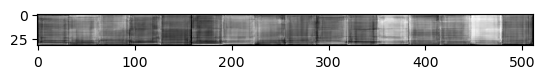

[EVAL] processed batch 0, disc_loss=0.008954199030995369 | ad_loss=5.16438627243042, recog_loss=17.09121322631836
[EVAL] processed batch 1, disc_loss=0.009589152410626411 | ad_loss=4.8545050621032715, recog_loss=17.6188907623291
[EVAL] processed batch 2, disc_loss=0.011147686280310154 | ad_loss=4.939088344573975, recog_loss=19.995702743530273
[EVAL] processed batch 3, disc_loss=0.010992147959768772 | ad_loss=4.862704277038574, recog_loss=15.057235717773438
[EVAL] processed batch 4, disc_loss=0.014438362792134285 | ad_loss=4.788268089294434, recog_loss=14.781766891479492
[EVAL] processed batch 5, disc_loss=0.010320562869310379 | ad_loss=4.783242225646973, recog_loss=16.203834533691406
[EVAL] processed batch 6, disc_loss=0.009395556524395943 | ad_loss=4.8180341720581055, recog_loss=20.99405288696289
[EVAL] processed batch 7, disc_loss=0.013956418260931969 | ad_loss=4.771018981933594, recog_loss=19.187835693359375
[EVAL] processed batch 8, disc_loss=0.009841378778219223 | ad_loss=4.975111

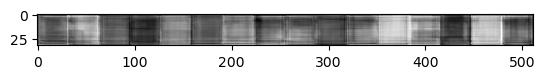

[EVAL] processed batch 0, disc_loss=0.011308385990560055 | ad_loss=4.683966159820557, recog_loss=17.169179916381836
[EVAL] processed batch 1, disc_loss=0.008861072361469269 | ad_loss=4.821874141693115, recog_loss=15.006946563720703
[EVAL] processed batch 2, disc_loss=0.009868668392300606 | ad_loss=4.6844096183776855, recog_loss=15.977503776550293
[EVAL] processed batch 3, disc_loss=0.011032434180378914 | ad_loss=4.689671516418457, recog_loss=17.00194549560547
[EVAL] processed batch 4, disc_loss=0.013538999482989311 | ad_loss=4.827146053314209, recog_loss=17.266555786132812
[EVAL] processed batch 5, disc_loss=0.008744551800191402 | ad_loss=4.767912864685059, recog_loss=15.93227767944336
[EVAL] processed batch 6, disc_loss=0.0091889388859272 | ad_loss=4.821915626525879, recog_loss=15.99630069732666
[EVAL] processed batch 7, disc_loss=0.011895949020981789 | ad_loss=4.722720146179199, recog_loss=12.817802429199219
[EVAL] processed batch 8, disc_loss=0.00948362611234188 | ad_loss=4.85725307

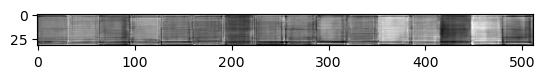

[EVAL] processed batch 0, disc_loss=0.007983566261827946 | ad_loss=5.125499725341797, recog_loss=18.550323486328125
[EVAL] processed batch 1, disc_loss=0.010454533621668816 | ad_loss=4.9794793128967285, recog_loss=16.071134567260742
[EVAL] processed batch 2, disc_loss=0.011413726955652237 | ad_loss=4.812323570251465, recog_loss=15.228378295898438
[EVAL] processed batch 3, disc_loss=0.011781703680753708 | ad_loss=4.930476665496826, recog_loss=17.688228607177734
[EVAL] processed batch 4, disc_loss=0.009404146112501621 | ad_loss=4.928227424621582, recog_loss=17.59543228149414
[EVAL] processed batch 5, disc_loss=0.009398449212312698 | ad_loss=4.992209434509277, recog_loss=18.763132095336914
[EVAL] processed batch 6, disc_loss=0.01156025379896164 | ad_loss=4.873699188232422, recog_loss=13.3030366897583
[EVAL] processed batch 7, disc_loss=0.010705279186367989 | ad_loss=4.721112251281738, recog_loss=17.220455169677734
[EVAL] processed batch 8, disc_loss=0.009306661784648895 | ad_loss=4.977380

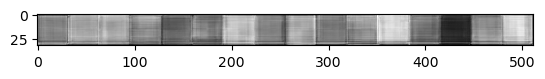

[EVAL] processed batch 0, disc_loss=0.012708853930234909 | ad_loss=4.704103469848633, recog_loss=15.252876281738281
[EVAL] processed batch 1, disc_loss=0.010365338064730167 | ad_loss=4.865228652954102, recog_loss=14.477029800415039
[EVAL] processed batch 2, disc_loss=0.009900778532028198 | ad_loss=4.814365386962891, recog_loss=18.683828353881836
[EVAL] processed batch 3, disc_loss=0.009375862777233124 | ad_loss=4.77945613861084, recog_loss=14.8663911819458
[EVAL] processed batch 4, disc_loss=0.008571998216211796 | ad_loss=4.847982883453369, recog_loss=16.453218460083008
[EVAL] processed batch 5, disc_loss=0.01230471208691597 | ad_loss=4.804394245147705, recog_loss=18.64278221130371
[EVAL] processed batch 6, disc_loss=0.014529243111610413 | ad_loss=4.538548469543457, recog_loss=16.533823013305664
[EVAL] processed batch 7, disc_loss=0.009884407743811607 | ad_loss=4.910945892333984, recog_loss=18.194183349609375
[EVAL] processed batch 8, disc_loss=0.010990597307682037 | ad_loss=5.01457309

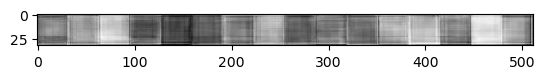

[EVAL] processed batch 0, disc_loss=0.01486124936491251 | ad_loss=4.473367691040039, recog_loss=19.180376052856445
[EVAL] processed batch 1, disc_loss=0.011386457830667496 | ad_loss=4.422157287597656, recog_loss=18.13669204711914
[EVAL] processed batch 2, disc_loss=0.010063933208584785 | ad_loss=4.5320587158203125, recog_loss=17.6583309173584
[EVAL] processed batch 3, disc_loss=0.010046041570603848 | ad_loss=4.359870433807373, recog_loss=16.782344818115234
[EVAL] processed batch 4, disc_loss=0.01151245553046465 | ad_loss=4.713626861572266, recog_loss=17.223947525024414
[EVAL] processed batch 5, disc_loss=0.007783160544931889 | ad_loss=4.706679344177246, recog_loss=18.093473434448242
[EVAL] processed batch 6, disc_loss=0.01131206564605236 | ad_loss=4.612321853637695, recog_loss=15.05560302734375
[EVAL] processed batch 7, disc_loss=0.009257912635803223 | ad_loss=4.611597061157227, recog_loss=13.570771217346191
[EVAL] processed batch 8, disc_loss=0.015020550228655338 | ad_loss=4.290682792

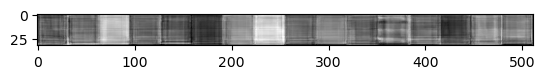

[EVAL] processed batch 0, disc_loss=0.01095677725970745 | ad_loss=4.536375045776367, recog_loss=17.221961975097656
[EVAL] processed batch 1, disc_loss=0.008961999788880348 | ad_loss=4.761053085327148, recog_loss=18.369285583496094
[EVAL] processed batch 2, disc_loss=0.010040588676929474 | ad_loss=4.826029300689697, recog_loss=15.59543514251709
[EVAL] processed batch 3, disc_loss=0.010339413769543171 | ad_loss=4.707499980926514, recog_loss=17.729318618774414
[EVAL] processed batch 4, disc_loss=0.010160593315958977 | ad_loss=4.6678571701049805, recog_loss=17.541366577148438
[EVAL] processed batch 5, disc_loss=0.009431131184101105 | ad_loss=5.038957118988037, recog_loss=16.925867080688477
[EVAL] processed batch 6, disc_loss=0.011595413088798523 | ad_loss=4.771871566772461, recog_loss=16.266136169433594
[EVAL] processed batch 7, disc_loss=0.009355390444397926 | ad_loss=4.704493522644043, recog_loss=15.5533447265625
[EVAL] processed batch 8, disc_loss=0.010509832762181759 | ad_loss=4.827945

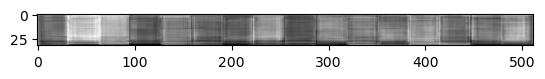

[EVAL] processed batch 0, disc_loss=0.010223225690424442 | ad_loss=4.7500715255737305, recog_loss=18.320274353027344
[EVAL] processed batch 1, disc_loss=0.012800254859030247 | ad_loss=4.517472743988037, recog_loss=15.578156471252441
[EVAL] processed batch 2, disc_loss=0.010195043869316578 | ad_loss=4.478981018066406, recog_loss=18.624486923217773
[EVAL] processed batch 3, disc_loss=0.01070063654333353 | ad_loss=4.502607345581055, recog_loss=17.36859130859375
[EVAL] processed batch 4, disc_loss=0.00993588101118803 | ad_loss=4.564031600952148, recog_loss=16.494646072387695
[EVAL] processed batch 5, disc_loss=0.009672265499830246 | ad_loss=4.6129560470581055, recog_loss=17.391706466674805
[EVAL] processed batch 6, disc_loss=0.00832538865506649 | ad_loss=4.841861724853516, recog_loss=15.255244255065918
[EVAL] processed batch 7, disc_loss=0.009454806335270405 | ad_loss=4.708122253417969, recog_loss=17.564958572387695
[EVAL] processed batch 8, disc_loss=0.0104437917470932 | ad_loss=4.6046247

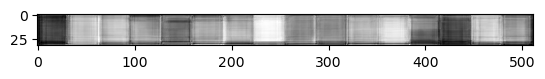

[EVAL] processed batch 0, disc_loss=0.009992813691496849 | ad_loss=4.5772786140441895, recog_loss=18.118751525878906
[EVAL] processed batch 1, disc_loss=0.010234329849481583 | ad_loss=4.605952262878418, recog_loss=16.230310440063477
[EVAL] processed batch 2, disc_loss=0.012828891165554523 | ad_loss=4.369955062866211, recog_loss=14.60774040222168
[EVAL] processed batch 3, disc_loss=0.01092899776995182 | ad_loss=4.570768356323242, recog_loss=17.696762084960938
[EVAL] processed batch 4, disc_loss=0.009591307491064072 | ad_loss=4.57955265045166, recog_loss=16.637046813964844
[EVAL] processed batch 5, disc_loss=0.011501225642859936 | ad_loss=4.427488803863525, recog_loss=15.060185432434082
[EVAL] processed batch 6, disc_loss=0.011022627353668213 | ad_loss=4.465816497802734, recog_loss=18.200883865356445
[EVAL] processed batch 7, disc_loss=0.009568603709340096 | ad_loss=4.593031406402588, recog_loss=14.89849853515625
[EVAL] processed batch 8, disc_loss=0.01093858852982521 | ad_loss=4.7252707

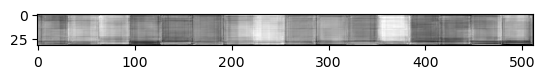

[EVAL] processed batch 0, disc_loss=0.011593473143875599 | ad_loss=4.750998497009277, recog_loss=16.45595359802246
[EVAL] processed batch 1, disc_loss=0.011841315776109695 | ad_loss=4.899547576904297, recog_loss=20.425540924072266
[EVAL] processed batch 2, disc_loss=0.011052867397665977 | ad_loss=5.09852933883667, recog_loss=16.11313247680664
[EVAL] processed batch 3, disc_loss=0.01029239036142826 | ad_loss=4.9051594734191895, recog_loss=18.01496124267578
[EVAL] processed batch 4, disc_loss=0.008964557200670242 | ad_loss=4.864074230194092, recog_loss=18.350147247314453
[EVAL] processed batch 5, disc_loss=0.009974690154194832 | ad_loss=4.808393955230713, recog_loss=14.29338550567627
[EVAL] processed batch 6, disc_loss=0.012263520620763302 | ad_loss=4.949283599853516, recog_loss=15.109842300415039
[EVAL] processed batch 7, disc_loss=0.010594615712761879 | ad_loss=4.861962795257568, recog_loss=14.947576522827148
[EVAL] processed batch 8, disc_loss=0.010451773181557655 | ad_loss=4.86209440

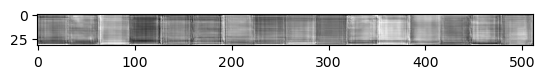

[EVAL] processed batch 0, disc_loss=0.010889948345720768 | ad_loss=4.570614337921143, recog_loss=17.32233238220215
[EVAL] processed batch 1, disc_loss=0.0110609270632267 | ad_loss=4.5234479904174805, recog_loss=19.181848526000977
[EVAL] processed batch 2, disc_loss=0.00894164852797985 | ad_loss=4.649996757507324, recog_loss=15.085976600646973
[EVAL] processed batch 3, disc_loss=0.010460954159498215 | ad_loss=4.645577907562256, recog_loss=13.969904899597168
[EVAL] processed batch 4, disc_loss=0.010235829278826714 | ad_loss=4.643627166748047, recog_loss=17.890178680419922
[EVAL] processed batch 5, disc_loss=0.016285739839076996 | ad_loss=4.525184631347656, recog_loss=18.95538902282715
[EVAL] processed batch 6, disc_loss=0.009050614200532436 | ad_loss=4.589623928070068, recog_loss=18.648832321166992
[EVAL] processed batch 7, disc_loss=0.011371433734893799 | ad_loss=4.457202911376953, recog_loss=12.8707275390625
[EVAL] processed batch 8, disc_loss=0.009603399783372879 | ad_loss=4.538823127

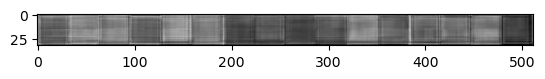

[EVAL] processed batch 0, disc_loss=0.009517408907413483 | ad_loss=4.9066877365112305, recog_loss=17.190645217895508
[EVAL] processed batch 1, disc_loss=0.01133985910564661 | ad_loss=4.901368618011475, recog_loss=17.329458236694336
[EVAL] processed batch 2, disc_loss=0.009833979420363903 | ad_loss=4.923464298248291, recog_loss=14.989174842834473
[EVAL] processed batch 3, disc_loss=0.016271863132715225 | ad_loss=4.956432342529297, recog_loss=15.48560619354248
[EVAL] processed batch 4, disc_loss=0.01045810617506504 | ad_loss=4.910845756530762, recog_loss=17.31117057800293
[EVAL] processed batch 5, disc_loss=0.010533404536545277 | ad_loss=4.87406063079834, recog_loss=17.876340866088867
[EVAL] processed batch 6, disc_loss=0.008978889323771 | ad_loss=5.036473751068115, recog_loss=15.63176155090332
[EVAL] processed batch 7, disc_loss=0.010194545611739159 | ad_loss=5.007613658905029, recog_loss=17.479652404785156
[EVAL] processed batch 8, disc_loss=0.008844880387187004 | ad_loss=4.85332441329

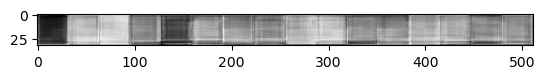

[EVAL] processed batch 0, disc_loss=0.01149428728967905 | ad_loss=4.445006847381592, recog_loss=16.76782989501953
[EVAL] processed batch 1, disc_loss=0.010199191980063915 | ad_loss=4.512272357940674, recog_loss=16.54711151123047
[EVAL] processed batch 2, disc_loss=0.009879885241389275 | ad_loss=4.733303070068359, recog_loss=17.676685333251953
[EVAL] processed batch 3, disc_loss=0.010143870487809181 | ad_loss=4.642519950866699, recog_loss=18.239057540893555
[EVAL] processed batch 4, disc_loss=0.010921968147158623 | ad_loss=4.504864692687988, recog_loss=18.798524856567383
[EVAL] processed batch 5, disc_loss=0.012039195746183395 | ad_loss=4.523472785949707, recog_loss=17.35890007019043
[EVAL] processed batch 6, disc_loss=0.011065004393458366 | ad_loss=4.445018768310547, recog_loss=15.538727760314941
[EVAL] processed batch 7, disc_loss=0.012358859181404114 | ad_loss=4.352647304534912, recog_loss=12.757964134216309
[EVAL] processed batch 8, disc_loss=0.010090306401252747 | ad_loss=4.6280651

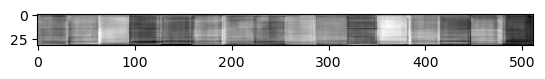

[EVAL] processed batch 0, disc_loss=0.009587286040186882 | ad_loss=4.665035247802734, recog_loss=17.310951232910156
[EVAL] processed batch 1, disc_loss=0.009860111400485039 | ad_loss=4.5788397789001465, recog_loss=17.099716186523438
[EVAL] processed batch 2, disc_loss=0.010747190564870834 | ad_loss=4.392469882965088, recog_loss=14.26861572265625
[EVAL] processed batch 3, disc_loss=0.010676298290491104 | ad_loss=4.667399883270264, recog_loss=18.90437126159668
[EVAL] processed batch 4, disc_loss=0.011558642610907555 | ad_loss=4.399601936340332, recog_loss=16.11214256286621
[EVAL] processed batch 5, disc_loss=0.010723263956606388 | ad_loss=4.589382171630859, recog_loss=15.966032028198242
[EVAL] processed batch 6, disc_loss=0.010205342434346676 | ad_loss=4.807651996612549, recog_loss=16.708507537841797
[EVAL] processed batch 7, disc_loss=0.010435482487082481 | ad_loss=4.663281440734863, recog_loss=19.760305404663086
[EVAL] processed batch 8, disc_loss=0.010160298086702824 | ad_loss=4.69740

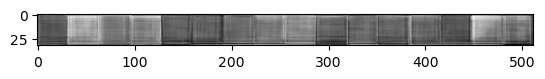

[EVAL] processed batch 0, disc_loss=0.009906796738505363 | ad_loss=4.952674865722656, recog_loss=15.3881254196167
[EVAL] processed batch 1, disc_loss=0.009191550314426422 | ad_loss=4.924239158630371, recog_loss=18.250905990600586
[EVAL] processed batch 2, disc_loss=0.011441684328019619 | ad_loss=4.929278373718262, recog_loss=15.145275115966797
[EVAL] processed batch 3, disc_loss=0.011287517845630646 | ad_loss=4.8735480308532715, recog_loss=16.692062377929688
[EVAL] processed batch 4, disc_loss=0.010940197855234146 | ad_loss=4.763036727905273, recog_loss=14.20071792602539
[EVAL] processed batch 5, disc_loss=0.010896897874772549 | ad_loss=4.8990888595581055, recog_loss=13.611740112304688
[EVAL] processed batch 6, disc_loss=0.011325230821967125 | ad_loss=4.813669204711914, recog_loss=15.390575408935547
[EVAL] processed batch 7, disc_loss=0.010434182360768318 | ad_loss=4.786389350891113, recog_loss=13.90516471862793
[EVAL] processed batch 8, disc_loss=0.010987482964992523 | ad_loss=4.83661

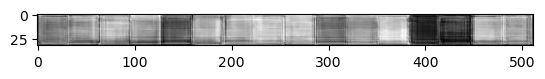

[EVAL] processed batch 0, disc_loss=0.010233836248517036 | ad_loss=4.916025161743164, recog_loss=19.467952728271484
[EVAL] processed batch 1, disc_loss=0.009181693196296692 | ad_loss=4.910599708557129, recog_loss=15.557002067565918
[EVAL] processed batch 2, disc_loss=0.00979050062596798 | ad_loss=4.904270172119141, recog_loss=18.072956085205078
[EVAL] processed batch 3, disc_loss=0.011634723283350468 | ad_loss=4.954706192016602, recog_loss=16.67829704284668
[EVAL] processed batch 4, disc_loss=0.01107464637607336 | ad_loss=4.757510185241699, recog_loss=16.62481689453125
[EVAL] processed batch 5, disc_loss=0.010608894750475883 | ad_loss=4.773608207702637, recog_loss=18.25563621520996
[EVAL] processed batch 6, disc_loss=0.009903431870043278 | ad_loss=4.826904296875, recog_loss=15.720305442810059
[EVAL] processed batch 7, disc_loss=0.009775109589099884 | ad_loss=4.848722457885742, recog_loss=16.395973205566406
[EVAL] processed batch 8, disc_loss=0.009731898084282875 | ad_loss=5.02335929870

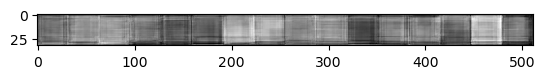

[EVAL] processed batch 0, disc_loss=0.01203578058630228 | ad_loss=4.751036643981934, recog_loss=12.726188659667969
[EVAL] processed batch 1, disc_loss=0.011656586080789566 | ad_loss=4.834171295166016, recog_loss=17.399099349975586
[EVAL] processed batch 2, disc_loss=0.011152651160955429 | ad_loss=5.0171308517456055, recog_loss=15.67024040222168
[EVAL] processed batch 3, disc_loss=0.011951412074267864 | ad_loss=5.096824645996094, recog_loss=18.00715446472168
[EVAL] processed batch 4, disc_loss=0.011968770995736122 | ad_loss=5.008115291595459, recog_loss=18.337757110595703
[EVAL] processed batch 5, disc_loss=0.00875608529895544 | ad_loss=4.995968341827393, recog_loss=17.061574935913086
[EVAL] processed batch 6, disc_loss=0.010046685114502907 | ad_loss=5.011943817138672, recog_loss=16.611371994018555
[EVAL] processed batch 7, disc_loss=0.01118413545191288 | ad_loss=4.900243282318115, recog_loss=15.819173812866211
[EVAL] processed batch 8, disc_loss=0.011593479663133621 | ad_loss=4.9638957

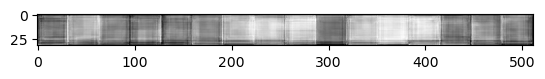

[EVAL] processed batch 0, disc_loss=0.01246109139174223 | ad_loss=4.367085933685303, recog_loss=15.421340942382812
[EVAL] processed batch 1, disc_loss=0.010384980589151382 | ad_loss=4.6528239250183105, recog_loss=17.361101150512695
[EVAL] processed batch 2, disc_loss=0.00995451770722866 | ad_loss=4.528621673583984, recog_loss=19.057703018188477
[EVAL] processed batch 3, disc_loss=0.008883047848939896 | ad_loss=4.538817405700684, recog_loss=17.534183502197266
[EVAL] processed batch 4, disc_loss=0.010157687589526176 | ad_loss=4.496212482452393, recog_loss=15.571211814880371
[EVAL] processed batch 5, disc_loss=0.010119685903191566 | ad_loss=4.484070777893066, recog_loss=14.519644737243652
[EVAL] processed batch 6, disc_loss=0.009736627340316772 | ad_loss=4.57499361038208, recog_loss=17.371849060058594
[EVAL] processed batch 7, disc_loss=0.010314342565834522 | ad_loss=4.557644844055176, recog_loss=20.201622009277344
[EVAL] processed batch 8, disc_loss=0.012523448094725609 | ad_loss=4.38643

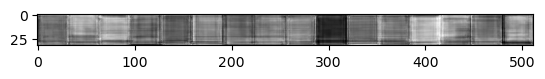

[EVAL] processed batch 0, disc_loss=0.010820185765624046 | ad_loss=4.573269367218018, recog_loss=17.891176223754883
[EVAL] processed batch 1, disc_loss=0.010345468297600746 | ad_loss=4.734501838684082, recog_loss=17.170387268066406
[EVAL] processed batch 2, disc_loss=0.011958448216319084 | ad_loss=4.557491302490234, recog_loss=18.927947998046875
[EVAL] processed batch 3, disc_loss=0.011644449084997177 | ad_loss=4.615156173706055, recog_loss=16.553686141967773
[EVAL] processed batch 4, disc_loss=0.009618996642529964 | ad_loss=4.534324645996094, recog_loss=15.826370239257812
[EVAL] processed batch 5, disc_loss=0.011229202151298523 | ad_loss=4.463829040527344, recog_loss=15.693829536437988
[EVAL] processed batch 6, disc_loss=0.010140102356672287 | ad_loss=4.683354377746582, recog_loss=15.76645278930664
[EVAL] processed batch 7, disc_loss=0.01123068667948246 | ad_loss=4.599880218505859, recog_loss=19.766347885131836
[EVAL] processed batch 8, disc_loss=0.011547531001269817 | ad_loss=4.58373

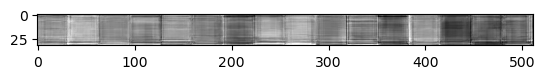

[EVAL] processed batch 0, disc_loss=0.01114538311958313 | ad_loss=4.627658843994141, recog_loss=16.268497467041016
[EVAL] processed batch 1, disc_loss=0.01093152817338705 | ad_loss=4.930886268615723, recog_loss=18.359027862548828
[EVAL] processed batch 2, disc_loss=0.013112839311361313 | ad_loss=4.747499465942383, recog_loss=14.648052215576172
[EVAL] processed batch 3, disc_loss=0.01182013563811779 | ad_loss=4.718924522399902, recog_loss=15.796131134033203
[EVAL] processed batch 4, disc_loss=0.01463034562766552 | ad_loss=4.754523277282715, recog_loss=16.3914852142334
[EVAL] processed batch 5, disc_loss=0.009843070060014725 | ad_loss=4.656139373779297, recog_loss=15.221091270446777
[EVAL] processed batch 6, disc_loss=0.01039312407374382 | ad_loss=4.640063285827637, recog_loss=17.684978485107422
[EVAL] processed batch 7, disc_loss=0.010777386836707592 | ad_loss=4.863609313964844, recog_loss=16.727663040161133
[EVAL] processed batch 8, disc_loss=0.01149461418390274 | ad_loss=4.81499099731

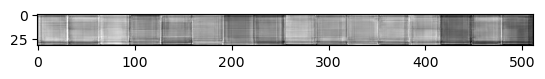

[EVAL] processed batch 0, disc_loss=0.009616538882255554 | ad_loss=5.073250770568848, recog_loss=17.39213752746582
[EVAL] processed batch 1, disc_loss=0.009973496198654175 | ad_loss=4.935609817504883, recog_loss=18.165424346923828
[EVAL] processed batch 2, disc_loss=0.01423346996307373 | ad_loss=4.908848762512207, recog_loss=14.524439811706543
[EVAL] processed batch 3, disc_loss=0.008182186633348465 | ad_loss=4.905718803405762, recog_loss=18.079265594482422
[EVAL] processed batch 4, disc_loss=0.010386266745626926 | ad_loss=4.8514556884765625, recog_loss=15.871345520019531
[EVAL] processed batch 5, disc_loss=0.00980528723448515 | ad_loss=4.897711753845215, recog_loss=16.280460357666016
[EVAL] processed batch 6, disc_loss=0.010770284570753574 | ad_loss=4.68818473815918, recog_loss=17.161935806274414
[EVAL] processed batch 7, disc_loss=0.011584244668483734 | ad_loss=4.796618938446045, recog_loss=15.756255149841309
[EVAL] processed batch 8, disc_loss=0.009147092700004578 | ad_loss=4.879858

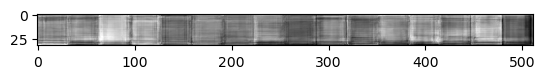

[EVAL] processed batch 0, disc_loss=0.008645962923765182 | ad_loss=5.069411277770996, recog_loss=15.569828987121582
[EVAL] processed batch 1, disc_loss=0.010878193192183971 | ad_loss=4.779870986938477, recog_loss=17.066001892089844
[EVAL] processed batch 2, disc_loss=0.009884333238005638 | ad_loss=4.874851703643799, recog_loss=15.323273658752441
[EVAL] processed batch 3, disc_loss=0.009276043623685837 | ad_loss=4.939477920532227, recog_loss=17.980119705200195
[EVAL] processed batch 4, disc_loss=0.010736281052231789 | ad_loss=4.830948829650879, recog_loss=16.780757904052734
[EVAL] processed batch 5, disc_loss=0.00933354627341032 | ad_loss=4.80119514465332, recog_loss=18.391035079956055
[EVAL] processed batch 6, disc_loss=0.010008911602199078 | ad_loss=5.016501426696777, recog_loss=17.62407112121582
[EVAL] processed batch 7, disc_loss=0.011401442810893059 | ad_loss=4.953718185424805, recog_loss=14.639791488647461
[EVAL] processed batch 8, disc_loss=0.017828185111284256 | ad_loss=4.833322

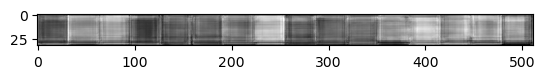

[EVAL] processed batch 0, disc_loss=0.009664708748459816 | ad_loss=4.964935302734375, recog_loss=17.916019439697266
[EVAL] processed batch 1, disc_loss=0.011084015481173992 | ad_loss=4.948381423950195, recog_loss=16.10369300842285
[EVAL] processed batch 2, disc_loss=0.009579733945429325 | ad_loss=5.1419525146484375, recog_loss=16.068504333496094
[EVAL] processed batch 3, disc_loss=0.011845403350889683 | ad_loss=4.887989044189453, recog_loss=17.265363693237305
[EVAL] processed batch 4, disc_loss=0.009856552816927433 | ad_loss=5.114701271057129, recog_loss=17.307090759277344
[EVAL] processed batch 5, disc_loss=0.010093395598232746 | ad_loss=5.042109489440918, recog_loss=18.026060104370117
[EVAL] processed batch 6, disc_loss=0.009988227859139442 | ad_loss=4.980121612548828, recog_loss=14.606710433959961
[EVAL] processed batch 7, disc_loss=0.009815875440835953 | ad_loss=5.088420867919922, recog_loss=16.498924255371094
[EVAL] processed batch 8, disc_loss=0.013919735327363014 | ad_loss=4.692

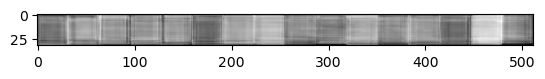

[EVAL] processed batch 0, disc_loss=0.010168279521167278 | ad_loss=5.010758876800537, recog_loss=14.648178100585938
[EVAL] processed batch 1, disc_loss=0.011368852108716965 | ad_loss=4.925241470336914, recog_loss=14.93276596069336
[EVAL] processed batch 2, disc_loss=0.011468734592199326 | ad_loss=4.785146236419678, recog_loss=12.415623664855957
[EVAL] processed batch 3, disc_loss=0.010295631363987923 | ad_loss=5.060511589050293, recog_loss=16.878774642944336
[EVAL] processed batch 4, disc_loss=0.0115476343780756 | ad_loss=4.781452655792236, recog_loss=15.959247589111328
[EVAL] processed batch 5, disc_loss=0.010608095675706863 | ad_loss=5.064583778381348, recog_loss=15.543583869934082
[EVAL] processed batch 6, disc_loss=0.013867909088730812 | ad_loss=4.818061351776123, recog_loss=18.6894474029541
[EVAL] processed batch 7, disc_loss=0.011201845481991768 | ad_loss=4.935801982879639, recog_loss=18.566028594970703
[EVAL] processed batch 8, disc_loss=0.013600708916783333 | ad_loss=4.89414691

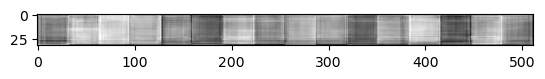

[EVAL] processed batch 0, disc_loss=0.007740578148514032 | ad_loss=5.05178165435791, recog_loss=17.28682518005371
[EVAL] processed batch 1, disc_loss=0.011660531163215637 | ad_loss=4.888096809387207, recog_loss=15.711482048034668
[EVAL] processed batch 2, disc_loss=0.013030890375375748 | ad_loss=4.858797073364258, recog_loss=17.609420776367188
[EVAL] processed batch 3, disc_loss=0.012537138536572456 | ad_loss=4.829442024230957, recog_loss=12.926775932312012
[EVAL] processed batch 4, disc_loss=0.009915203787386417 | ad_loss=4.8635406494140625, recog_loss=15.486899375915527
[EVAL] processed batch 5, disc_loss=0.010955389589071274 | ad_loss=4.835194110870361, recog_loss=14.042459487915039
[EVAL] processed batch 6, disc_loss=0.010608644224703312 | ad_loss=5.141221046447754, recog_loss=14.194784164428711
[EVAL] processed batch 7, disc_loss=0.010610062628984451 | ad_loss=4.873394966125488, recog_loss=15.815215110778809
[EVAL] processed batch 8, disc_loss=0.011962713673710823 | ad_loss=4.9352

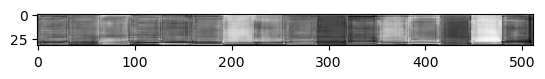

[EVAL] processed batch 0, disc_loss=0.011155577376484871 | ad_loss=4.488091468811035, recog_loss=15.177143096923828
[EVAL] processed batch 1, disc_loss=0.010117684490978718 | ad_loss=4.740785598754883, recog_loss=16.672428131103516
[EVAL] processed batch 2, disc_loss=0.009401531890034676 | ad_loss=4.71932315826416, recog_loss=16.011213302612305
[EVAL] processed batch 3, disc_loss=0.009981151670217514 | ad_loss=4.62557315826416, recog_loss=14.288935661315918
[EVAL] processed batch 4, disc_loss=0.012101568281650543 | ad_loss=4.515308380126953, recog_loss=14.389280319213867
[EVAL] processed batch 5, disc_loss=0.00957114901393652 | ad_loss=4.610603332519531, recog_loss=14.259442329406738
[EVAL] processed batch 6, disc_loss=0.011450002901256084 | ad_loss=4.532832145690918, recog_loss=17.75004005432129
[EVAL] processed batch 7, disc_loss=0.008334923535585403 | ad_loss=4.65546989440918, recog_loss=15.685785293579102
[EVAL] processed batch 8, disc_loss=0.011363565921783447 | ad_loss=4.54447746

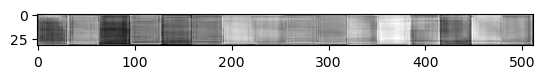

[EVAL] processed batch 0, disc_loss=0.01088334247469902 | ad_loss=4.512821197509766, recog_loss=18.559417724609375
[EVAL] processed batch 1, disc_loss=0.01107108872383833 | ad_loss=4.396105766296387, recog_loss=12.514337539672852
[EVAL] processed batch 2, disc_loss=0.010748317465186119 | ad_loss=4.338091850280762, recog_loss=15.079205513000488
[EVAL] processed batch 3, disc_loss=0.01123323105275631 | ad_loss=4.322479248046875, recog_loss=15.746410369873047
[EVAL] processed batch 4, disc_loss=0.010382430627942085 | ad_loss=4.621890068054199, recog_loss=15.140559196472168
[EVAL] processed batch 5, disc_loss=0.009740588255226612 | ad_loss=4.398646354675293, recog_loss=14.071525573730469
[EVAL] processed batch 6, disc_loss=0.011156569235026836 | ad_loss=4.347868919372559, recog_loss=17.14606285095215
[EVAL] processed batch 7, disc_loss=0.00957922637462616 | ad_loss=4.515683650970459, recog_loss=15.645366668701172
[EVAL] processed batch 8, disc_loss=0.009577048942446709 | ad_loss=4.58121585

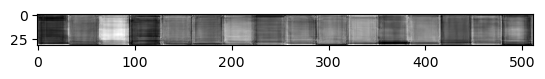

[EVAL] processed batch 0, disc_loss=0.00989782065153122 | ad_loss=4.596689224243164, recog_loss=15.826482772827148
[EVAL] processed batch 1, disc_loss=0.010118240490555763 | ad_loss=4.474719047546387, recog_loss=15.606795310974121
[EVAL] processed batch 2, disc_loss=0.009559735655784607 | ad_loss=4.727878570556641, recog_loss=16.37057113647461
[EVAL] processed batch 3, disc_loss=0.010382191278040409 | ad_loss=4.458108425140381, recog_loss=15.663529396057129
[EVAL] processed batch 4, disc_loss=0.012161307036876678 | ad_loss=4.600340843200684, recog_loss=20.57952308654785
[EVAL] processed batch 5, disc_loss=0.009889505803585052 | ad_loss=4.532242774963379, recog_loss=16.184059143066406
[EVAL] processed batch 6, disc_loss=0.009072227403521538 | ad_loss=4.6867995262146, recog_loss=12.976994514465332
[EVAL] processed batch 7, disc_loss=0.010305400937795639 | ad_loss=4.4619598388671875, recog_loss=17.86334991455078
[EVAL] processed batch 8, disc_loss=0.012252256274223328 | ad_loss=4.35912084

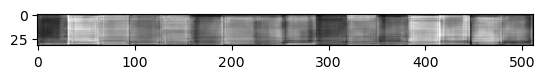

[EVAL] processed batch 0, disc_loss=0.01022887509316206 | ad_loss=4.777012825012207, recog_loss=15.347199440002441
[EVAL] processed batch 1, disc_loss=0.009651132859289646 | ad_loss=4.657106399536133, recog_loss=15.0206298828125
[EVAL] processed batch 2, disc_loss=0.009850440546870232 | ad_loss=4.762487888336182, recog_loss=16.350704193115234
[EVAL] processed batch 3, disc_loss=0.009977759793400764 | ad_loss=4.829412937164307, recog_loss=16.172775268554688
[EVAL] processed batch 4, disc_loss=0.011149376630783081 | ad_loss=4.777835845947266, recog_loss=16.874582290649414
[EVAL] processed batch 5, disc_loss=0.0114468764513731 | ad_loss=4.630860328674316, recog_loss=15.595673561096191
[EVAL] processed batch 6, disc_loss=0.010102145373821259 | ad_loss=4.748011589050293, recog_loss=14.774738311767578
[EVAL] processed batch 7, disc_loss=0.01126901526004076 | ad_loss=4.963177680969238, recog_loss=14.80771541595459
[EVAL] processed batch 8, disc_loss=0.009117145091295242 | ad_loss=4.9213085174

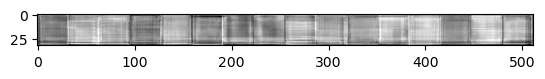

[EVAL] processed batch 0, disc_loss=0.011011394672095776 | ad_loss=4.960721969604492, recog_loss=18.737707138061523
[EVAL] processed batch 1, disc_loss=0.013151165097951889 | ad_loss=4.551506042480469, recog_loss=16.117225646972656
[EVAL] processed batch 2, disc_loss=0.011242888867855072 | ad_loss=4.674178600311279, recog_loss=15.020343780517578
[EVAL] processed batch 3, disc_loss=0.01142212375998497 | ad_loss=4.647097587585449, recog_loss=16.31964111328125
[EVAL] processed batch 4, disc_loss=0.008317582309246063 | ad_loss=4.857403755187988, recog_loss=13.825994491577148
[EVAL] processed batch 5, disc_loss=0.011450808495283127 | ad_loss=4.722276210784912, recog_loss=18.423673629760742
[EVAL] processed batch 6, disc_loss=0.010912556201219559 | ad_loss=4.7564697265625, recog_loss=15.78422737121582
[EVAL] processed batch 7, disc_loss=0.011673375964164734 | ad_loss=4.665429592132568, recog_loss=17.97835922241211
[EVAL] processed batch 8, disc_loss=0.01068407017737627 | ad_loss=4.6926860809

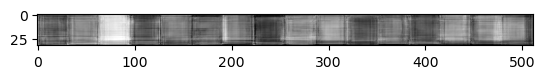

[EVAL] processed batch 0, disc_loss=0.009965937584638596 | ad_loss=4.680566787719727, recog_loss=12.378093719482422
[EVAL] processed batch 1, disc_loss=0.010511474683880806 | ad_loss=4.627956867218018, recog_loss=16.176998138427734
[EVAL] processed batch 2, disc_loss=0.010628127492964268 | ad_loss=4.610048294067383, recog_loss=15.078130722045898
[EVAL] processed batch 3, disc_loss=0.008882706053555012 | ad_loss=4.6582441329956055, recog_loss=15.962320327758789
[EVAL] processed batch 4, disc_loss=0.010423732921481133 | ad_loss=4.596136093139648, recog_loss=17.767385482788086
[EVAL] processed batch 5, disc_loss=0.01101488247513771 | ad_loss=4.615246772766113, recog_loss=14.415521621704102
[EVAL] processed batch 6, disc_loss=0.008886588737368584 | ad_loss=4.603973388671875, recog_loss=16.286611557006836
[EVAL] processed batch 7, disc_loss=0.01143401488661766 | ad_loss=4.47986364364624, recog_loss=14.917815208435059
[EVAL] processed batch 8, disc_loss=0.011477407068014145 | ad_loss=4.46207

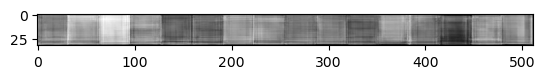

[EVAL] processed batch 0, disc_loss=0.012265504337847233 | ad_loss=4.787167549133301, recog_loss=15.288946151733398
[EVAL] processed batch 1, disc_loss=0.008974472060799599 | ad_loss=4.95648193359375, recog_loss=17.220638275146484
[EVAL] processed batch 2, disc_loss=0.011133634485304356 | ad_loss=4.749129295349121, recog_loss=14.28367805480957
[EVAL] processed batch 3, disc_loss=0.012676481157541275 | ad_loss=4.79841423034668, recog_loss=13.97791862487793
[EVAL] processed batch 4, disc_loss=0.011119973845779896 | ad_loss=4.800698757171631, recog_loss=12.444286346435547
[EVAL] processed batch 5, disc_loss=0.008778255432844162 | ad_loss=4.8022589683532715, recog_loss=16.384571075439453
[EVAL] processed batch 6, disc_loss=0.010130364447832108 | ad_loss=4.792898654937744, recog_loss=16.759014129638672
[EVAL] processed batch 7, disc_loss=0.009674837812781334 | ad_loss=4.836720943450928, recog_loss=16.811100006103516
[EVAL] processed batch 8, disc_loss=0.009710066020488739 | ad_loss=4.846285

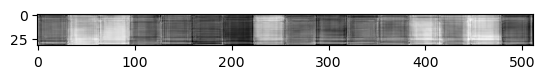

[EVAL] processed batch 0, disc_loss=0.010630320757627487 | ad_loss=4.666304588317871, recog_loss=17.61676025390625
[EVAL] processed batch 1, disc_loss=0.008815735578536987 | ad_loss=4.754692077636719, recog_loss=12.909699440002441
[EVAL] processed batch 2, disc_loss=0.009117954410612583 | ad_loss=4.698826313018799, recog_loss=14.827462196350098
[EVAL] processed batch 3, disc_loss=0.013423585332930088 | ad_loss=4.615161895751953, recog_loss=18.568326950073242
[EVAL] processed batch 4, disc_loss=0.009660997427999973 | ad_loss=4.795505523681641, recog_loss=19.1976375579834
[EVAL] processed batch 5, disc_loss=0.011155745945870876 | ad_loss=4.7532219886779785, recog_loss=16.571189880371094
[EVAL] processed batch 6, disc_loss=0.01046004332602024 | ad_loss=4.555887222290039, recog_loss=14.203947067260742
[EVAL] processed batch 7, disc_loss=0.010579153895378113 | ad_loss=4.585107803344727, recog_loss=14.411612510681152
[EVAL] processed batch 8, disc_loss=0.010502185672521591 | ad_loss=4.667868

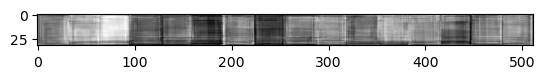

[EVAL] processed batch 0, disc_loss=0.012467434629797935 | ad_loss=4.652056694030762, recog_loss=19.049612045288086
[EVAL] processed batch 1, disc_loss=0.013294626027345657 | ad_loss=4.7450761795043945, recog_loss=14.214018821716309
[EVAL] processed batch 2, disc_loss=0.01012474112212658 | ad_loss=4.646128177642822, recog_loss=17.331520080566406
[EVAL] processed batch 3, disc_loss=0.009073549881577492 | ad_loss=4.726627349853516, recog_loss=17.215011596679688
[EVAL] processed batch 4, disc_loss=0.01006173063069582 | ad_loss=4.666646957397461, recog_loss=15.99766731262207
[EVAL] processed batch 5, disc_loss=0.00878334790468216 | ad_loss=4.825056076049805, recog_loss=15.36324405670166
[EVAL] processed batch 6, disc_loss=0.009175851941108704 | ad_loss=4.995820999145508, recog_loss=14.520584106445312
[EVAL] processed batch 7, disc_loss=0.009550662711262703 | ad_loss=4.773129463195801, recog_loss=16.60719871520996
[EVAL] processed batch 8, disc_loss=0.01076191570609808 | ad_loss=4.706197738

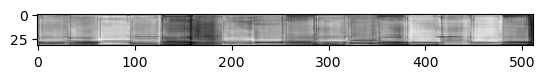

[EVAL] processed batch 0, disc_loss=0.008371641859412193 | ad_loss=4.799219608306885, recog_loss=16.3265438079834
[EVAL] processed batch 1, disc_loss=0.011018630117177963 | ad_loss=4.518732070922852, recog_loss=19.538511276245117
[EVAL] processed batch 2, disc_loss=0.011682208627462387 | ad_loss=4.583329200744629, recog_loss=15.80275821685791
[EVAL] processed batch 3, disc_loss=0.01166808232665062 | ad_loss=4.551198482513428, recog_loss=12.701275825500488
[EVAL] processed batch 4, disc_loss=0.010584344156086445 | ad_loss=4.515395164489746, recog_loss=17.116962432861328
[EVAL] processed batch 5, disc_loss=0.011562535539269447 | ad_loss=4.497602462768555, recog_loss=14.83101749420166
[EVAL] processed batch 6, disc_loss=0.00899849459528923 | ad_loss=4.668550968170166, recog_loss=16.08228302001953
[EVAL] processed batch 7, disc_loss=0.008542606607079506 | ad_loss=4.767395973205566, recog_loss=18.460134506225586
[EVAL] processed batch 8, disc_loss=0.011284952983260155 | ad_loss=4.5766201019

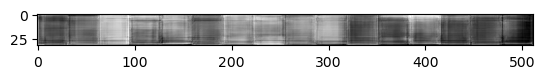

[EVAL] processed batch 0, disc_loss=0.011540085077285767 | ad_loss=4.3700995445251465, recog_loss=16.222679138183594
[EVAL] processed batch 1, disc_loss=0.013196645304560661 | ad_loss=4.235228061676025, recog_loss=14.08301830291748
[EVAL] processed batch 2, disc_loss=0.01168745569884777 | ad_loss=4.3182477951049805, recog_loss=15.17919921875
[EVAL] processed batch 3, disc_loss=0.011047828942537308 | ad_loss=4.498196601867676, recog_loss=15.190034866333008
[EVAL] processed batch 4, disc_loss=0.011189866811037064 | ad_loss=4.571008682250977, recog_loss=17.14816665649414
[EVAL] processed batch 5, disc_loss=0.010667749680578709 | ad_loss=4.520964622497559, recog_loss=16.63271141052246
[EVAL] processed batch 6, disc_loss=0.010921797715127468 | ad_loss=4.612951278686523, recog_loss=14.972846984863281
[EVAL] processed batch 7, disc_loss=0.010210344567894936 | ad_loss=4.648571491241455, recog_loss=19.51443099975586
[EVAL] processed batch 8, disc_loss=0.009325338527560234 | ad_loss=4.4977502822

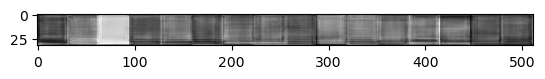

[EVAL] processed batch 0, disc_loss=0.008946524932980537 | ad_loss=4.823333263397217, recog_loss=17.31647491455078
[EVAL] processed batch 1, disc_loss=0.00928422436118126 | ad_loss=4.844067573547363, recog_loss=16.03666877746582
[EVAL] processed batch 2, disc_loss=0.010462949052453041 | ad_loss=4.835285186767578, recog_loss=12.768087387084961
[EVAL] processed batch 3, disc_loss=0.011026217602193356 | ad_loss=4.6894402503967285, recog_loss=16.429189682006836
[EVAL] processed batch 4, disc_loss=0.014557672664523125 | ad_loss=4.903499603271484, recog_loss=13.531295776367188
[EVAL] processed batch 5, disc_loss=0.009732933714985847 | ad_loss=4.759800434112549, recog_loss=14.676823616027832
[EVAL] processed batch 6, disc_loss=0.011597715318202972 | ad_loss=4.584650039672852, recog_loss=15.442231178283691
[EVAL] processed batch 7, disc_loss=0.010101769119501114 | ad_loss=4.837367534637451, recog_loss=16.196475982666016
[EVAL] processed batch 8, disc_loss=0.007872471585869789 | ad_loss=4.71741

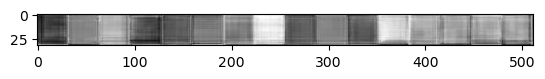

[EVAL] processed batch 0, disc_loss=0.010446574538946152 | ad_loss=4.647184371948242, recog_loss=14.338445663452148
[EVAL] processed batch 1, disc_loss=0.010467409156262875 | ad_loss=4.730995178222656, recog_loss=16.846622467041016
[EVAL] processed batch 2, disc_loss=0.009729900397360325 | ad_loss=4.541631698608398, recog_loss=18.012935638427734
[EVAL] processed batch 3, disc_loss=0.009952903725206852 | ad_loss=4.4644880294799805, recog_loss=16.054645538330078
[EVAL] processed batch 4, disc_loss=0.00878944806754589 | ad_loss=4.735374450683594, recog_loss=15.877120018005371
[EVAL] processed batch 5, disc_loss=0.011194700375199318 | ad_loss=4.3440141677856445, recog_loss=15.46326732635498
[EVAL] processed batch 6, disc_loss=0.01032695360481739 | ad_loss=4.508019924163818, recog_loss=14.458334922790527
[EVAL] processed batch 7, disc_loss=0.009824633598327637 | ad_loss=4.520219326019287, recog_loss=19.997636795043945
[EVAL] processed batch 8, disc_loss=0.008952166885137558 | ad_loss=4.7400

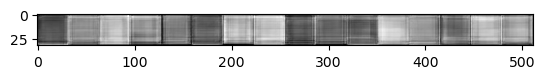

[EVAL] processed batch 0, disc_loss=0.012877179309725761 | ad_loss=4.983163833618164, recog_loss=12.598770141601562
[EVAL] processed batch 1, disc_loss=0.010194944217801094 | ad_loss=4.958172798156738, recog_loss=16.032493591308594
[EVAL] processed batch 2, disc_loss=0.009633611887693405 | ad_loss=4.875789165496826, recog_loss=13.827912330627441
[EVAL] processed batch 3, disc_loss=0.00969666987657547 | ad_loss=5.021515846252441, recog_loss=15.47247314453125
[EVAL] processed batch 4, disc_loss=0.012680061161518097 | ad_loss=4.678161144256592, recog_loss=15.801464080810547
[EVAL] processed batch 5, disc_loss=0.0102882981300354 | ad_loss=4.814229965209961, recog_loss=14.407964706420898
[EVAL] processed batch 6, disc_loss=0.012518790550529957 | ad_loss=4.91680908203125, recog_loss=15.971396446228027
[EVAL] processed batch 7, disc_loss=0.011583898216485977 | ad_loss=4.907020568847656, recog_loss=14.589801788330078
[EVAL] processed batch 8, disc_loss=0.011927534826099873 | ad_loss=4.84644079

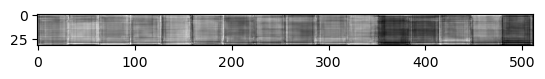

[EVAL] processed batch 0, disc_loss=0.011591317132115364 | ad_loss=4.549436569213867, recog_loss=14.807144165039062
[EVAL] processed batch 1, disc_loss=0.0094112204387784 | ad_loss=4.619781970977783, recog_loss=14.82593822479248
[EVAL] processed batch 2, disc_loss=0.009492190554738045 | ad_loss=4.618282318115234, recog_loss=18.605573654174805
[EVAL] processed batch 3, disc_loss=0.010567928664386272 | ad_loss=4.795955657958984, recog_loss=16.560489654541016
[EVAL] processed batch 4, disc_loss=0.009454028680920601 | ad_loss=4.530088424682617, recog_loss=16.421058654785156
[EVAL] processed batch 5, disc_loss=0.010978223755955696 | ad_loss=4.456357002258301, recog_loss=14.08182430267334
[EVAL] processed batch 6, disc_loss=0.010960659012198448 | ad_loss=4.505609035491943, recog_loss=17.060380935668945
[EVAL] processed batch 7, disc_loss=0.00983315147459507 | ad_loss=4.706326484680176, recog_loss=16.281869888305664
[EVAL] processed batch 8, disc_loss=0.009067032486200333 | ad_loss=4.63965892

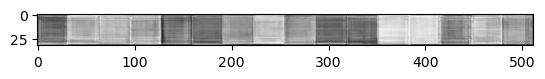

[EVAL] processed batch 0, disc_loss=0.010210386477410793 | ad_loss=4.792374134063721, recog_loss=16.669979095458984
[EVAL] processed batch 1, disc_loss=0.010393712669610977 | ad_loss=4.729799747467041, recog_loss=15.03260612487793
[EVAL] processed batch 2, disc_loss=0.011622361838817596 | ad_loss=4.744575500488281, recog_loss=13.606561660766602
[EVAL] processed batch 3, disc_loss=0.01164322905242443 | ad_loss=4.852605819702148, recog_loss=15.471935272216797
[EVAL] processed batch 4, disc_loss=0.013079782016575336 | ad_loss=4.706694602966309, recog_loss=14.670848846435547
[EVAL] processed batch 5, disc_loss=0.01015026681125164 | ad_loss=4.844906330108643, recog_loss=14.421565055847168
[EVAL] processed batch 6, disc_loss=0.00888868048787117 | ad_loss=4.8716840744018555, recog_loss=13.757529258728027
[EVAL] processed batch 7, disc_loss=0.01210620068013668 | ad_loss=4.733414649963379, recog_loss=11.442577362060547
[EVAL] processed batch 8, disc_loss=0.008537898771464825 | ad_loss=4.8661203

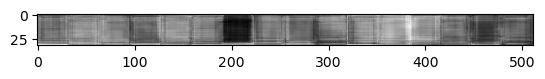

[EVAL] processed batch 0, disc_loss=0.008342173881828785 | ad_loss=4.720187664031982, recog_loss=17.431705474853516
[EVAL] processed batch 1, disc_loss=0.010078050196170807 | ad_loss=4.719280242919922, recog_loss=18.72952651977539
[EVAL] processed batch 2, disc_loss=0.01144252810627222 | ad_loss=4.642263889312744, recog_loss=13.737282752990723
[EVAL] processed batch 3, disc_loss=0.009771225973963737 | ad_loss=4.7417731285095215, recog_loss=14.001673698425293
[EVAL] processed batch 4, disc_loss=0.009100222960114479 | ad_loss=4.8280839920043945, recog_loss=15.920475959777832
[EVAL] processed batch 5, disc_loss=0.010348442941904068 | ad_loss=4.667696475982666, recog_loss=15.221854209899902
[EVAL] processed batch 6, disc_loss=0.009307308122515678 | ad_loss=4.708354949951172, recog_loss=16.149364471435547
[EVAL] processed batch 7, disc_loss=0.01053878478705883 | ad_loss=4.863953590393066, recog_loss=16.796092987060547
[EVAL] processed batch 8, disc_loss=0.009906980209052563 | ad_loss=4.7550

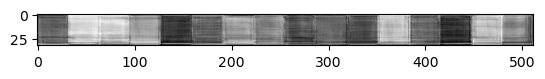

[EVAL] processed batch 0, disc_loss=0.011433836072683334 | ad_loss=4.696828842163086, recog_loss=16.055164337158203
[EVAL] processed batch 1, disc_loss=0.009231962263584137 | ad_loss=4.781840801239014, recog_loss=14.403159141540527
[EVAL] processed batch 2, disc_loss=0.010192399844527245 | ad_loss=4.891444206237793, recog_loss=16.331817626953125
[EVAL] processed batch 3, disc_loss=0.010104551911354065 | ad_loss=4.794694900512695, recog_loss=16.975666046142578
[EVAL] processed batch 4, disc_loss=0.011002015322446823 | ad_loss=4.825033664703369, recog_loss=14.460103988647461
[EVAL] processed batch 5, disc_loss=0.008878277614712715 | ad_loss=4.923037052154541, recog_loss=15.999801635742188
[EVAL] processed batch 6, disc_loss=0.01164315827190876 | ad_loss=4.7870988845825195, recog_loss=13.371685028076172
[EVAL] processed batch 7, disc_loss=0.010853830724954605 | ad_loss=4.826572418212891, recog_loss=17.13155174255371
[EVAL] processed batch 8, disc_loss=0.01072513684630394 | ad_loss=4.80417

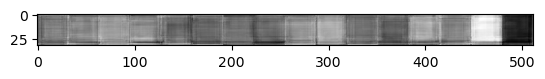

[EVAL] processed batch 0, disc_loss=0.010507579892873764 | ad_loss=4.758459568023682, recog_loss=15.68303394317627
[EVAL] processed batch 1, disc_loss=0.011563686653971672 | ad_loss=4.926319122314453, recog_loss=14.809147834777832
[EVAL] processed batch 2, disc_loss=0.011760847643017769 | ad_loss=4.799647331237793, recog_loss=13.452742576599121
[EVAL] processed batch 3, disc_loss=0.008935376070439816 | ad_loss=4.92929744720459, recog_loss=16.767459869384766
[EVAL] processed batch 4, disc_loss=0.010309265926480293 | ad_loss=4.679342269897461, recog_loss=18.837770462036133
[EVAL] processed batch 5, disc_loss=0.010190613567829132 | ad_loss=4.711871147155762, recog_loss=15.954306602478027
[EVAL] processed batch 6, disc_loss=0.009186523035168648 | ad_loss=4.880434036254883, recog_loss=16.370874404907227
[EVAL] processed batch 7, disc_loss=0.008544525131583214 | ad_loss=4.841704368591309, recog_loss=16.93740463256836
[EVAL] processed batch 8, disc_loss=0.011313353665173054 | ad_loss=4.735848

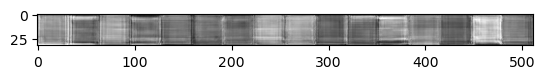

[EVAL] processed batch 0, disc_loss=0.009571149945259094 | ad_loss=4.687675476074219, recog_loss=16.050689697265625
[EVAL] processed batch 1, disc_loss=0.009005215018987656 | ad_loss=4.788732051849365, recog_loss=16.573341369628906
[EVAL] processed batch 2, disc_loss=0.009125602431595325 | ad_loss=4.727316856384277, recog_loss=14.956502914428711
[EVAL] processed batch 3, disc_loss=0.00827009417116642 | ad_loss=4.723739147186279, recog_loss=15.547591209411621
[EVAL] processed batch 4, disc_loss=0.008987585082650185 | ad_loss=4.733506202697754, recog_loss=19.482044219970703
[EVAL] processed batch 5, disc_loss=0.010443830862641335 | ad_loss=4.601602077484131, recog_loss=15.298721313476562
[EVAL] processed batch 6, disc_loss=0.00978290569037199 | ad_loss=4.824512481689453, recog_loss=18.205787658691406
[EVAL] processed batch 7, disc_loss=0.010138554498553276 | ad_loss=4.706007957458496, recog_loss=14.962699890136719
[EVAL] processed batch 8, disc_loss=0.010024006478488445 | ad_loss=4.71843

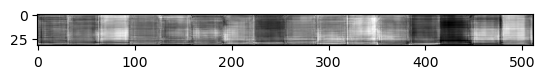

[EVAL] processed batch 0, disc_loss=0.010264415293931961 | ad_loss=4.697649002075195, recog_loss=17.34469223022461
[EVAL] processed batch 1, disc_loss=0.01165220607072115 | ad_loss=4.638774871826172, recog_loss=17.21315574645996
[EVAL] processed batch 2, disc_loss=0.009070847183465958 | ad_loss=5.040623664855957, recog_loss=14.580901145935059
[EVAL] processed batch 3, disc_loss=0.0110815754160285 | ad_loss=4.919768810272217, recog_loss=15.67392349243164
[EVAL] processed batch 4, disc_loss=0.010618255473673344 | ad_loss=4.997483253479004, recog_loss=15.74311351776123
[EVAL] processed batch 5, disc_loss=0.008711978793144226 | ad_loss=5.094965934753418, recog_loss=15.179231643676758
[EVAL] processed batch 6, disc_loss=0.009897259064018726 | ad_loss=4.90155553817749, recog_loss=13.84899616241455
[EVAL] processed batch 7, disc_loss=0.009181137196719646 | ad_loss=4.790297508239746, recog_loss=14.203459739685059
[EVAL] processed batch 8, disc_loss=0.010984236374497414 | ad_loss=4.882445812225

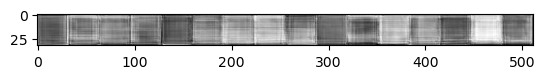

[EVAL] processed batch 0, disc_loss=0.010852701030671597 | ad_loss=4.793004035949707, recog_loss=13.64783763885498
[EVAL] processed batch 1, disc_loss=0.010945616289973259 | ad_loss=4.60483980178833, recog_loss=17.196826934814453
[EVAL] processed batch 2, disc_loss=0.009661351330578327 | ad_loss=4.866571426391602, recog_loss=13.297816276550293
[EVAL] processed batch 3, disc_loss=0.011199367232620716 | ad_loss=4.824211120605469, recog_loss=14.33375072479248
[EVAL] processed batch 4, disc_loss=0.010801724158227444 | ad_loss=4.960977554321289, recog_loss=16.947797775268555
[EVAL] processed batch 5, disc_loss=0.010939673520624638 | ad_loss=4.779126167297363, recog_loss=15.220843315124512
[EVAL] processed batch 6, disc_loss=0.009123675525188446 | ad_loss=5.056373119354248, recog_loss=16.224811553955078
[EVAL] processed batch 7, disc_loss=0.009916725568473339 | ad_loss=4.914202690124512, recog_loss=15.280035018920898
[EVAL] processed batch 8, disc_loss=0.010321437381207943 | ad_loss=4.862602

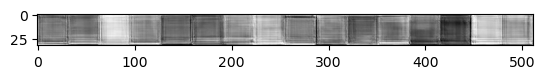

[EVAL] processed batch 0, disc_loss=0.011251382529735565 | ad_loss=4.616464614868164, recog_loss=18.445390701293945
[EVAL] processed batch 1, disc_loss=0.011000723578035831 | ad_loss=4.55335807800293, recog_loss=15.170428276062012
[EVAL] processed batch 2, disc_loss=0.009179690852761269 | ad_loss=4.743485927581787, recog_loss=14.233939170837402
[EVAL] processed batch 3, disc_loss=0.009886080399155617 | ad_loss=4.614381790161133, recog_loss=17.90093994140625
[EVAL] processed batch 4, disc_loss=0.009925379417836666 | ad_loss=4.533075332641602, recog_loss=14.783670425415039
[EVAL] processed batch 5, disc_loss=0.009650135412812233 | ad_loss=4.51164436340332, recog_loss=15.554069519042969
[EVAL] processed batch 6, disc_loss=0.010382023639976978 | ad_loss=4.454329490661621, recog_loss=14.47268009185791
[EVAL] processed batch 7, disc_loss=0.010276904329657555 | ad_loss=4.705196380615234, recog_loss=13.184883117675781
[EVAL] processed batch 8, disc_loss=0.011204488575458527 | ad_loss=4.4674692

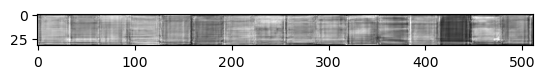

[EVAL] processed batch 0, disc_loss=0.010377018712460995 | ad_loss=4.41737174987793, recog_loss=16.164268493652344
[EVAL] processed batch 1, disc_loss=0.012314903549849987 | ad_loss=4.395571708679199, recog_loss=16.008832931518555
[EVAL] processed batch 2, disc_loss=0.01015414483845234 | ad_loss=4.601628303527832, recog_loss=14.99022102355957
[EVAL] processed batch 3, disc_loss=0.010029475204646587 | ad_loss=4.568516731262207, recog_loss=16.980615615844727
[EVAL] processed batch 4, disc_loss=0.01005084440112114 | ad_loss=4.626145839691162, recog_loss=16.579113006591797
[EVAL] processed batch 5, disc_loss=0.008843056857585907 | ad_loss=4.68272590637207, recog_loss=13.978676795959473
[EVAL] processed batch 6, disc_loss=0.01100725308060646 | ad_loss=4.565486907958984, recog_loss=17.008941650390625
[EVAL] processed batch 7, disc_loss=0.009428052231669426 | ad_loss=4.768235206604004, recog_loss=17.08163833618164
[EVAL] processed batch 8, disc_loss=0.008617796935141087 | ad_loss=4.7015547752

KeyboardInterrupt: 

In [13]:
generator = Generator()
discriminator = Discriminator()
encoder = Encoder()
recognizer = Recognizer()

# Load in the recognizer
recog_path = "./trained_rec/model_recognizer_bs8_lr0.0005_epoch49"
recognizer = load_model(recognizer, recog_path)

# generator = load_model(generator, "main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)_generator_epoch9.pt")
# generator, encoder, discriminator = load_models_of_same_batch(generator, encoder, discriminator, filename_prefix="main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)", epoch_number=9)

train_gan(encoder_lr=1e-6, generator_lr=1e-6, discriminator_lr=1e-6,
          num_epochs=10000, batch_size=32,
          encoder=encoder, generator=generator ,discriminator=discriminator,
          train_line_dataset=line_dataset_train, val_line_dataset=line_dataset_val, 
          recognizer=recognizer, num_generator_updates_per_discriminator_update=10, recognizer_downscale_factor=1)